In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm.notebook import tqdm
import glob
!pip install mtcnn
from mtcnn.mtcnn import MTCNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.0 MB/s eta 0:00:00


2025-05-20 15:17:44.773036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747754264.940658      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747754264.989499      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:

# Define constants
IMAGE_SIZE = 128
BATCH_SIZE = 32
UTK_FACE_PATH = "/kaggle/input/utkface-new/UTKFace" 

In [6]:
# Age groups definition
AGE_GROUPS = [
    (0, 5),   # Young children
    (6, 10),  # Children
    (11, 15), # Adolescents
    (16, 20), # Teenagers
    (21, 30), # Young adults
    (31, 40), # Adults
    (41, 50), # Middle-aged
    (51, 70), # Seniors
    (71, 116) # Elderly
]


In [7]:
# Face detection with MTCNN
detector = MTCNN()

I0000 00:00:1747754289.664939      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747754289.665677      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [15]:
def extract_age_from_filename(filename):
    try:
        age = int(os.path.basename(filename).split('_')[0])
        return age
    except:
        return None

In [16]:

def extract_face(filename, required_size=(IMAGE_SIZE, IMAGE_SIZE)):
    try:
        img = Image.open(filename).convert('RGB')
        pixels = np.asarray(img)
        results = detector.detect_faces(pixels)

        if not results:
            # Fall back to entire image if face detection fails
            img = img.resize(required_size)
            face_array = np.asarray(img)
            face_array = (face_array - 127.5) / 127.5
            return face_array

        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        face = pixels[max(0, y1):y2, max(0, x1):x2]

        image = Image.fromarray(face)
        image = image.resize(required_size)
        face_array = np.asarray(image)
        face_array = (face_array - 127.5) / 127.5

        return face_array
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None


In [25]:

def load_dataset(batch_size=BATCH_SIZE, max_samples=5000):
    print("Loading dataset...")
    all_image_paths = glob.glob(os.path.join(UTK_FACE_PATH, "*.jpg"))


    all_image_paths = all_image_paths[:max_samples]

    face_images = []
    ages = []

    for path in tqdm(all_image_paths):
        age = extract_age_from_filename(path)
        if age is not None:
            face = extract_face(path)
            if face is not None:
                face_images.append(face)
                ages.append(age)

    face_images = np.array(face_images)
    ages = np.array(ages)

    print(f"Loaded {len(face_images)} face images")

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((face_images, ages))
    dataset = dataset.shuffle(buffer_size=len(face_images))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset, face_images, ages

In [26]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

# Helper function to convert age to one-hot encoded group
"""
def age_to_group(age):
    for i, (min_age, max_age) in enumerate(AGE_GROUPS):
        if min_age <= age <= max_age:
            return i
    return 0  # Default to first group if no match
"""
def age_to_group(age):
    group_idx = 0  # Default value
    for i, (min_age, max_age) in enumerate(AGE_GROUPS):
        if min_age <= age <= max_age:
            group_idx = i
            break
    return group_idx



In [27]:

def age_to_onehot(age):
    group_idx = age_to_group(age)
    return tf.one_hot(group_idx, len(AGE_GROUPS))


In [33]:

# Generator model
def build_generator(latent_dim=100, num_age_groups=len(AGE_GROUPS)):
    noise_input = layers.Input(shape=(latent_dim,))
    age_input = layers.Input(shape=(num_age_groups,))
    image_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # Encoder for identity preservation
    x_id = layers.Conv2D(64, 4, strides=2, padding='same')(image_input)
    x_id = layers.LeakyReLU(0.2)(x_id)
    x_id = layers.Conv2D(128, 4, strides=2, padding='same')(x_id)
    x_id = layers.BatchNormalization()(x_id)
    x_id = layers.LeakyReLU(0.2)(x_id)
    x_id = layers.Conv2D(256, 4, strides=2, padding='same')(x_id)
    x_id = layers.BatchNormalization()(x_id)
    x_id = layers.LeakyReLU(0.2)(x_id)
    id_features = layers.Conv2D(512, 4, strides=2, padding='same')(x_id)
    id_features = layers.BatchNormalization()(id_features)
    id_features = layers.LeakyReLU(0.2)(id_features)

    # Process noise and age condition
    x = layers.Dense(8*8*256)(noise_input)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((8, 8, 256))(x)

    # Process age information
    age_features = layers.Dense(8*8*256)(age_input)
    age_features = layers.LeakyReLU(0.2)(age_features)
    age_features = layers.Reshape((8, 8, 256))(age_features)

    # Combine features
    x = layers.Concatenate()([x, age_features, id_features])

    # Upsampling decoder with attention mechanism
    x = layers.Conv2DTranspose(512, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Output layer with tanh activation
    x = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)

    # Create attention mask for identity preservation
    attention_mask = layers.Conv2D(1, 4, padding='same', activation='sigmoid')(id_features)
    attention_mask = layers.UpSampling2D(size=16)(attention_mask)

    # Apply attention mechanism to preserve identity in non-age-related areas
    output = layers.Multiply()([x, attention_mask]) + layers.Multiply()([image_input, 1 - attention_mask])

    model = Model([noise_input, age_input, image_input], output, name="generator")
    return model


In [34]:

# Discriminator model with age classification
def build_discriminator(num_age_groups=len(AGE_GROUPS)):
    input_image = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    x = layers.Conv2D(64, 4, strides=2, padding='same')(input_image)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Flatten()(x)

    # Real/fake output
    validity = layers.Dense(1, activation='sigmoid')(x)

    # Age classification output
    age_features = layers.Dense(256)(x)
    age_features = layers.LeakyReLU(0.2)(age_features)
    age_class = layers.Dense(num_age_groups, activation='softmax')(age_features)

    # Identity features for identity preservation loss
    identity_features = layers.Dense(128)(x)

    model = Model(input_image, [validity, age_class, identity_features], name="discriminator")
    return model


In [35]:

# Identity preservation model
def build_identity_model():
    input_image = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    x = layers.Conv2D(64, 3, padding='same')(input_image)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(256, activation='relu')(x)

    model = Model(input_image, x, name="identity_model")
    return model

In [36]:
class AgeProgressionGAN(Model):
    def __init__(self, generator, discriminator, identity_model, latent_dim=100):
        super(AgeProgressionGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.identity_model = identity_model
        self.latent_dim = latent_dim

        # Freeze identity model during training
        self.identity_model.trainable = False




In [37]:
class AgeProgressionGAN(Model):
    def __init__(self, generator, discriminator, identity_model, latent_dim=100):
        super(AgeProgressionGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.identity_model = identity_model
        self.latent_dim = latent_dim

        # Freeze identity model during training
        self.identity_model.trainable = False

    def compile(self, optimizer, gen_optimizer, disc_optimizer): # Add the standard 'optimizer' argument
        super(AgeProgressionGAN, self).compile(optimizer=optimizer)
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.adv_loss_fn = tf.keras.losses.BinaryCrossentropy()
        self.age_loss_fn = tf.keras.losses.CategoricalCrossentropy()
        self.identity_loss_fn = tf.keras.losses.CosineSimilarity(axis=1)
        self.recon_loss_fn = tf.keras.losses.MeanAbsoluteError()

        # Metrics
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="gen_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="disc_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def train_step(self, data):
        real_images, real_ages = data
        batch_size = tf.shape(real_images)[0]

        # Convert ages to one-hot encoded groups
        real_age_groups = tf.map_fn(
            lambda x: age_to_onehot(x),
            real_ages,
            fn_output_signature=tf.float32
        )

        # Generate random noise
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate random target ages (different from source ages)
        random_age_groups = []
        for i in range(batch_size):
            current_group = tf.argmax(real_age_groups[i])
            available_groups = list(range(len(AGE_GROUPS)))
            if current_group < len(AGE_GROUPS):
                available_groups.remove(int(current_group))
            target_group = np.random.choice(available_groups)
            random_age_groups.append(tf.one_hot(target_group, len(AGE_GROUPS)))

        random_age_groups = tf.stack(random_age_groups)

        # Train the discriminator
        with tf.GradientTape() as disc_tape:
            # Generate fake images
            fake_images = self.generator([noise, random_age_groups, real_images])

            # Get discriminator outputs
            real_validity, real_age_pred, real_id_features = self.discriminator(real_images)
            fake_validity, fake_age_pred, fake_id_features = self.discriminator(fake_images)

            # Calculate discriminator losses
            disc_real_loss = self.adv_loss_fn(tf.ones_like(real_validity), real_validity)
            disc_fake_loss = self.adv_loss_fn(tf.zeros_like(fake_validity), fake_validity)
            disc_adv_loss = 0.5 * (disc_real_loss + disc_fake_loss)

            # Age classification loss
            disc_age_loss = self.age_loss_fn(real_age_groups, real_age_pred)

            # Total discriminator loss
            disc_loss = disc_adv_loss + 2.0 * disc_age_loss

        # Apply gradients
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as gen_tape:
            # Generate fake images
            fake_images = self.generator([noise, random_age_groups, real_images])

            # Get discriminator outputs for fake images
            fake_validity, fake_age_pred, fake_id_features = self.discriminator(fake_images)

            # Get identity features
            real_identity = self.identity_model(real_images)
            fake_identity = self.identity_model(fake_images)

            # Calculate generator losses
            gen_adv_loss = self.adv_loss_fn(tf.ones_like(fake_validity), fake_validity)

            # Age classification loss
            gen_age_loss = self.age_loss_fn(random_age_groups, fake_age_pred)

            # Identity preservation loss
            gen_id_loss = -self.identity_loss_fn(real_identity, fake_identity)  # Negated to maximize similarity

            # Reconstruction loss
            gen_recon_loss = self.recon_loss_fn(real_images, fake_images)

            # Total generator loss with weighting
            gen_loss = gen_adv_loss + 2.0 * gen_age_loss + 5.0 * gen_id_loss + 1.0 * gen_recon_loss

        # Apply generator gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        # Update metrics
        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_loss_tracker.update_state(disc_loss)

        return {
            "gen_loss": self.gen_loss_tracker.result(),
            "disc_loss": self.disc_loss_tracker.result(),
            "adv_loss": gen_adv_loss,
            "age_loss": gen_age_loss,
            "id_loss": gen_id_loss,
            "recon_loss": gen_recon_loss
        }


In [38]:
def train_model(dataset, epochs=100, sample_interval=5):
    # Create directories for samples and models
    os.makedirs("samples", exist_ok=True)
    os.makedirs("models", exist_ok=True)

    # Get a sample batch for visualization
    sample_images, sample_ages = next(iter(dataset.take(1)))
    sample_images = sample_images[:5]  # Take first 5 images
    sample_noise = tf.random.normal((5, latent_dim))

    # Setup for visualization during training
    def save_sample_images(epoch):
        # Generate images for different age groups
        plt.figure(figsize=(15, 10))

        # Display original images
        for i in range(5):
            plt.subplot(5, len(AGE_GROUPS) + 1, i * (len(AGE_GROUPS) + 1) + 1)
            plt.imshow(((sample_images[i] + 1) * 127.5).numpy().astype(np.uint8))
            plt.title(f"Original (Age: {sample_ages[i].numpy()})")
            plt.axis('off')

        # Generate and display aged images
        for i in range(5):
            for j in range(len(AGE_GROUPS)):
                target_age = tf.one_hot(j, len(AGE_GROUPS))
                target_age = tf.expand_dims(target_age, 0)

                # Generate aged image
                gen_img = gan_model.generator([
                    tf.expand_dims(sample_noise[i], 0),
                    target_age,
                    tf.expand_dims(sample_images[i], 0)
                ])

                plt.subplot(5, len(AGE_GROUPS) + 1, i * (len(AGE_GROUPS) + 1) + j + 2)
                plt.imshow(((gen_img[0] + 1) * 127.5).numpy().astype(np.uint8))
                min_age, max_age = AGE_GROUPS[j]
                plt.title(f"Age: {min_age}-{max_age}")
                plt.axis('off')

        plt.tight_layout()
        plt.savefig(f"samples/epoch_{epoch:04d}.png")
        plt.close()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training step
        total_gen_loss = 0
        total_disc_loss = 0
        steps = 0

        for batch_images, batch_ages in tqdm(dataset):
            metrics = gan_model.train_step((batch_images, batch_ages))
            total_gen_loss += metrics["gen_loss"]
            total_disc_loss += metrics["disc_loss"]
            steps += 1

            # Print progress every 10 steps
            if steps % 10 == 0:
                print(f"Step {steps}: G_loss={metrics['gen_loss']:.4f}, D_loss={metrics['disc_loss']:.4f}")

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}: G_loss={total_gen_loss/steps:.4f}, D_loss={total_disc_loss/steps:.4f}")

        # Save sample images every sample_interval epochs
        if (epoch + 1) % sample_interval == 0 or epoch == 0:
            save_sample_images(epoch + 1)

        # Save model weights every 20 epochs
        if (epoch + 1) % 20 == 0:
            gan_model.generator.save(f"models/generator_epoch_{epoch+1}.h5")
            gan_model.discriminator.save(f"models/discriminator_epoch_{epoch+1}.h5")

    # Save final model
    gan_model.generator.save("models/generator_final.h5")
    gan_model.discriminator.save("models/discriminator_final.h5")

    return gan_model


Loading dataset...


  0%|          | 0/5000 [00:00<?, ?it/s]

Loaded 5000 face images


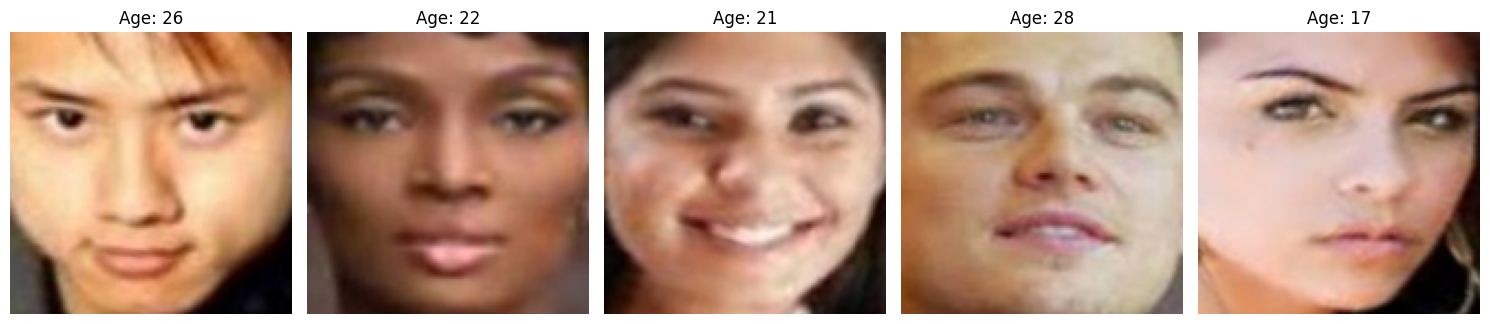

Building models...


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          3,136 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 64, 64, 64)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 128)    │        131,200 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 128)    │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 32, 32, 128)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 256)    │        524,544 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 9)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 16, 16, 256)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16384)          │      1,654,784 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16384)          │        163,840 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 8, 8, 512)      │      2,097,664 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 16384)          │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 16384)          │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 8, 8, 512)      │          2,048 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 15,607,620 (59.54 MB)

 Trainable params: 15,604,036 (59.52 MB)

 Non-trainable params: 3,584 (14.00 KB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │          3,136 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_9 (LeakyReLU) │ (None, 64, 64, 64)     │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │        131,200 │ leaky_re_lu_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 32, 32, 128)    │            512 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_10            │ (None, 32, 32, 128)    │              0 │ batch_normalization_6… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 256)    │        524,544 │ leaky_re_lu_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 16, 16, 256)    │          1,024 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_11            │ (None, 16, 16, 256)    │              0 │ batch_normalization_7… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 512)      │      2,097,664 │ leaky_re_lu_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 8, 8, 512)      │          2,048 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_12            │ (None, 8, 8, 512)      │              0 │ batch_normalization_8… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 32768)          │              0 │ leaky_re_lu_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │      8,388,864 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_13            │ (None, 256)            │              0 │ dense_3[0][0]          │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)      

 Total params: 15,378,506 (58.66 MB)

 Trainable params: 15,376,714 (58.66 MB)

 Non-trainable params: 1,792 (7.00 KB)

Training model...

Epoch 1/100


  0%|          | 0/157 [00:00<?, ?it/s]

I0000 00:00:1747756447.990183      35 cuda_dnn.cc:529] Loaded cuDNN version 90300
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['dense_5/kernel', 'dense_5/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Step 10: G_loss=10.2840, D_loss=4.6096
Step 20: G_loss=9.6249, D_loss=4.3976
Step 30: G_loss=9.2826, D_loss=4.2949
Step 40: G_loss=9.4174, D_loss=4.1982
Step 50: G_loss=9.6678, D_loss=4.0761
Step 60: G_loss=9.9490, D_loss=4.0209
Step 70: G_loss=10.1422, D_loss=4.0122
Step 80: G_loss=10.3032, D_loss=3.9570
Step 90: G_loss=10.4448, D_loss=3.9169
Step 100: G_loss=10.3898, D_loss=3.8887
Step 110: G_loss=10.3447, D_loss=3.8940
Step 120: G_loss=10.1659, D_loss=3.9040
Step 130: G_loss=9.9745, D_loss=3.8889
Step 140: G_loss=9.8129, D_loss=3.8739
Step 150: G_loss=9.6474, D_loss=3.8605
Epoch 1/100: G_loss=9.9612, D_loss=4.0764

Epoch 2/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=9.4099, D_loss=3.8264
Step 20: G_loss=9.2788, D_loss=3.7989
Step 30: G_loss=9.1572, D_loss=3.7744
Step 40: G_loss=9.0382, D_loss=3.7514
Step 50: G_loss=8.9193, D_loss=3.7315
Step 60: G_loss=8.8099, D_loss=3.7217
Step 70: G_loss=8.7144, D_loss=3.7138
Step 80: G_loss=8.6204, D_loss=3.6981
Step 90: G_loss=8.5346, D_loss=3.6888
Step 100: G_loss=8.4508, D_loss=3.6795
Step 110: G_loss=8.3719, D_loss=3.6682
Step 120: G_loss=8.3027, D_loss=3.6600
Step 130: G_loss=8.2334, D_loss=3.6477
Step 140: G_loss=8.1612, D_loss=3.6338
Step 150: G_loss=8.0932, D_loss=3.6216
Epoch 2/100: G_loss=8.6874, D_loss=3.7096

Epoch 3/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.9884, D_loss=3.6018
Step 20: G_loss=7.9303, D_loss=3.5833
Step 30: G_loss=7.8737, D_loss=3.5658
Step 40: G_loss=7.8139, D_loss=3.5545
Step 50: G_loss=7.7536, D_loss=3.5428
Step 60: G_loss=7.6997, D_loss=3.5291
Step 70: G_loss=7.6483, D_loss=3.5215
Step 80: G_loss=7.5980, D_loss=3.5135
Step 90: G_loss=7.5486, D_loss=3.5088
Step 100: G_loss=7.5018, D_loss=3.5023
Step 110: G_loss=7.4605, D_loss=3.4934
Step 120: G_loss=7.4180, D_loss=3.4836
Step 130: G_loss=7.3791, D_loss=3.4794
Step 140: G_loss=7.3431, D_loss=3.4691
Step 150: G_loss=7.3045, D_loss=3.4586
Epoch 3/100: G_loss=7.6240, D_loss=3.5218

Epoch 4/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.2411, D_loss=3.4423
Step 20: G_loss=7.2083, D_loss=3.4278
Step 30: G_loss=7.1747, D_loss=3.4171
Step 40: G_loss=7.1415, D_loss=3.4048
Step 50: G_loss=7.1093, D_loss=3.3957
Step 60: G_loss=7.0792, D_loss=3.3875
Step 70: G_loss=7.0496, D_loss=3.3761
Step 80: G_loss=7.0217, D_loss=3.3681
Step 90: G_loss=6.9928, D_loss=3.3622
Step 100: G_loss=6.9651, D_loss=3.3561
Step 110: G_loss=6.9386, D_loss=3.3504
Step 120: G_loss=6.9112, D_loss=3.3455
Step 130: G_loss=6.8854, D_loss=3.3386
Step 140: G_loss=6.8645, D_loss=3.3318
Step 150: G_loss=6.8414, D_loss=3.3276
Epoch 4/100: G_loss=7.0320, D_loss=3.3770

Epoch 5/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.8018, D_loss=3.3094
Step 20: G_loss=6.7792, D_loss=3.2982
Step 30: G_loss=6.7559, D_loss=3.2880
Step 40: G_loss=6.7344, D_loss=3.2761
Step 50: G_loss=6.7162, D_loss=3.2669
Step 60: G_loss=6.6952, D_loss=3.2594
Step 70: G_loss=6.6782, D_loss=3.2494
Step 80: G_loss=6.6579, D_loss=3.2438
Step 90: G_loss=6.6392, D_loss=3.2388
Step 100: G_loss=6.6230, D_loss=3.2319
Step 110: G_loss=6.6080, D_loss=3.2251
Step 120: G_loss=6.5932, D_loss=3.2177
Step 130: G_loss=6.5769, D_loss=3.2127
Step 140: G_loss=6.5611, D_loss=3.2054
Step 150: G_loss=6.5454, D_loss=3.1976
Epoch 5/100: G_loss=6.6667, D_loss=3.2491

Epoch 6/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.5191, D_loss=3.1846
Step 20: G_loss=6.5047, D_loss=3.1733
Step 30: G_loss=6.4912, D_loss=3.1608
Step 40: G_loss=6.4770, D_loss=3.1537
Step 50: G_loss=6.4646, D_loss=3.1431
Step 60: G_loss=6.4519, D_loss=3.1364
Step 70: G_loss=6.4406, D_loss=3.1284
Step 80: G_loss=6.4274, D_loss=3.1217
Step 90: G_loss=6.4142, D_loss=3.1129
Step 100: G_loss=6.4026, D_loss=3.1060
Step 110: G_loss=6.3904, D_loss=3.0989
Step 120: G_loss=6.3810, D_loss=3.0907
Step 130: G_loss=6.3700, D_loss=3.0841
Step 140: G_loss=6.3612, D_loss=3.0756
Step 150: G_loss=6.3518, D_loss=3.0679
Epoch 6/100: G_loss=6.4315, D_loss=3.1236

Epoch 7/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.3335, D_loss=3.0544
Step 20: G_loss=6.3225, D_loss=3.0429
Step 30: G_loss=6.3115, D_loss=3.0311
Step 40: G_loss=6.3024, D_loss=3.0214
Step 50: G_loss=6.2940, D_loss=3.0127
Step 60: G_loss=6.2850, D_loss=3.0016
Step 70: G_loss=6.2782, D_loss=2.9922
Step 80: G_loss=6.2708, D_loss=2.9833
Step 90: G_loss=6.2622, D_loss=2.9755
Step 100: G_loss=6.2554, D_loss=2.9677
Step 110: G_loss=6.2476, D_loss=2.9600
Step 120: G_loss=6.2409, D_loss=2.9517
Step 130: G_loss=6.2349, D_loss=2.9446
Step 140: G_loss=6.2297, D_loss=2.9380
Step 150: G_loss=6.2243, D_loss=2.9313
Epoch 7/100: G_loss=6.2740, D_loss=2.9884

Epoch 8/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.2131, D_loss=2.9144
Step 20: G_loss=6.2077, D_loss=2.9033
Step 30: G_loss=6.2020, D_loss=2.8932
Step 40: G_loss=6.1959, D_loss=2.8816
Step 50: G_loss=6.1897, D_loss=2.8708
Step 60: G_loss=6.1853, D_loss=2.8618
Step 70: G_loss=6.1786, D_loss=2.8515
Step 80: G_loss=6.1728, D_loss=2.8417
Step 90: G_loss=6.1680, D_loss=2.8338
Step 100: G_loss=6.1660, D_loss=2.8263
Step 110: G_loss=6.1601, D_loss=2.8176
Step 120: G_loss=6.1559, D_loss=2.8088
Step 130: G_loss=6.1510, D_loss=2.8016
Step 140: G_loss=6.1482, D_loss=2.7936
Step 150: G_loss=6.1431, D_loss=2.7859
Epoch 8/100: G_loss=6.1764, D_loss=2.8469

Epoch 9/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.1345, D_loss=2.7690
Step 20: G_loss=6.1336, D_loss=2.7575
Step 30: G_loss=6.1324, D_loss=2.7466
Step 40: G_loss=6.1371, D_loss=2.7358
Step 50: G_loss=6.1410, D_loss=2.7236
Step 60: G_loss=6.1399, D_loss=2.7116
Step 70: G_loss=6.1359, D_loss=2.7026
Step 80: G_loss=6.1329, D_loss=2.6939
Step 90: G_loss=6.1306, D_loss=2.6840
Step 100: G_loss=6.1297, D_loss=2.6752
Step 110: G_loss=6.1264, D_loss=2.6669
Step 120: G_loss=6.1249, D_loss=2.6591
Step 130: G_loss=6.1217, D_loss=2.6503
Step 140: G_loss=6.1207, D_loss=2.6425
Step 150: G_loss=6.1171, D_loss=2.6360
Epoch 9/100: G_loss=6.1305, D_loss=2.6982

Epoch 10/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.1133, D_loss=2.6204
Step 20: G_loss=6.1115, D_loss=2.6110
Step 30: G_loss=6.1095, D_loss=2.6005
Step 40: G_loss=6.1091, D_loss=2.5906
Step 50: G_loss=6.1091, D_loss=2.5811
Step 60: G_loss=6.1099, D_loss=2.5720
Step 70: G_loss=6.1078, D_loss=2.5624
Step 80: G_loss=6.1055, D_loss=2.5528
Step 90: G_loss=6.1035, D_loss=2.5442
Step 100: G_loss=6.1030, D_loss=2.5354
Step 110: G_loss=6.1014, D_loss=2.5266
Step 120: G_loss=6.1017, D_loss=2.5179
Step 130: G_loss=6.1034, D_loss=2.5099
Step 140: G_loss=6.1026, D_loss=2.5011
Step 150: G_loss=6.1008, D_loss=2.4933
Epoch 10/100: G_loss=6.1063, D_loss=2.5556

Epoch 11/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.0995, D_loss=2.4779
Step 20: G_loss=6.1002, D_loss=2.4689
Step 30: G_loss=6.1002, D_loss=2.4603
Step 40: G_loss=6.0990, D_loss=2.4510
Step 50: G_loss=6.0988, D_loss=2.4419
Step 60: G_loss=6.0986, D_loss=2.4330
Step 70: G_loss=6.0979, D_loss=2.4247
Step 80: G_loss=6.0993, D_loss=2.4156
Step 90: G_loss=6.0986, D_loss=2.4069
Step 100: G_loss=6.0962, D_loss=2.3987
Step 110: G_loss=6.0960, D_loss=2.3907
Step 120: G_loss=6.0970, D_loss=2.3832
Step 130: G_loss=6.0975, D_loss=2.3754
Step 140: G_loss=6.0970, D_loss=2.3682
Step 150: G_loss=6.0965, D_loss=2.3601
Epoch 11/100: G_loss=6.0982, D_loss=2.4181

Epoch 12/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.0953, D_loss=2.3454
Step 20: G_loss=6.0953, D_loss=2.3366
Step 30: G_loss=6.0963, D_loss=2.3281
Step 40: G_loss=6.0995, D_loss=2.3203
Step 50: G_loss=6.1002, D_loss=2.3116
Step 60: G_loss=6.1016, D_loss=2.3032
Step 70: G_loss=6.1009, D_loss=2.2953
Step 80: G_loss=6.1005, D_loss=2.2869
Step 90: G_loss=6.1049, D_loss=2.2788
Step 100: G_loss=6.1102, D_loss=2.2708
Step 110: G_loss=6.1120, D_loss=2.2631
Step 120: G_loss=6.1145, D_loss=2.2545
Step 130: G_loss=6.1155, D_loss=2.2464
Step 140: G_loss=6.1186, D_loss=2.2398
Step 150: G_loss=6.1205, D_loss=2.2334
Epoch 12/100: G_loss=6.1057, D_loss=2.2886

Epoch 13/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.1219, D_loss=2.2219
Step 20: G_loss=6.1221, D_loss=2.2150
Step 30: G_loss=6.1230, D_loss=2.2069
Step 40: G_loss=6.1226, D_loss=2.1994
Step 50: G_loss=6.1247, D_loss=2.1919
Step 60: G_loss=6.1261, D_loss=2.1846
Step 70: G_loss=6.1286, D_loss=2.1774
Step 80: G_loss=6.1319, D_loss=2.1708
Step 90: G_loss=6.1352, D_loss=2.1639
Step 100: G_loss=6.1394, D_loss=2.1570
Step 110: G_loss=6.1404, D_loss=2.1503
Step 120: G_loss=6.1414, D_loss=2.1435
Step 130: G_loss=6.1429, D_loss=2.1365
Step 140: G_loss=6.1428, D_loss=2.1308
Step 150: G_loss=6.1436, D_loss=2.1240
Epoch 13/100: G_loss=6.1324, D_loss=2.1724

Epoch 14/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.1448, D_loss=2.1140
Step 20: G_loss=6.1443, D_loss=2.1075
Step 30: G_loss=6.1441, D_loss=2.1006
Step 40: G_loss=6.1459, D_loss=2.0940
Step 50: G_loss=6.1473, D_loss=2.0871
Step 60: G_loss=6.1475, D_loss=2.0802
Step 70: G_loss=6.1493, D_loss=2.0736
Step 80: G_loss=6.1515, D_loss=2.0668
Step 90: G_loss=6.1530, D_loss=2.0600
Step 100: G_loss=6.1546, D_loss=2.0535
Step 110: G_loss=6.1567, D_loss=2.0468
Step 120: G_loss=6.1585, D_loss=2.0408
Step 130: G_loss=6.1628, D_loss=2.0352
Step 140: G_loss=6.1669, D_loss=2.0294
Step 150: G_loss=6.1702, D_loss=2.0238
Epoch 14/100: G_loss=6.1532, D_loss=2.0683

Epoch 15/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.1740, D_loss=2.0144
Step 20: G_loss=6.1753, D_loss=2.0080
Step 30: G_loss=6.1762, D_loss=2.0022
Step 40: G_loss=6.1806, D_loss=1.9962
Step 50: G_loss=6.1829, D_loss=1.9909
Step 60: G_loss=6.1836, D_loss=1.9847
Step 70: G_loss=6.1848, D_loss=1.9789
Step 80: G_loss=6.1856, D_loss=1.9729
Step 90: G_loss=6.1870, D_loss=1.9673
Step 100: G_loss=6.1883, D_loss=1.9615
Step 110: G_loss=6.1895, D_loss=1.9558
Step 120: G_loss=6.1894, D_loss=1.9504
Step 130: G_loss=6.1900, D_loss=1.9455
Step 140: G_loss=6.1898, D_loss=1.9398
Step 150: G_loss=6.1912, D_loss=1.9344
Epoch 15/100: G_loss=6.1844, D_loss=1.9741

Epoch 16/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.1963, D_loss=1.9263
Step 20: G_loss=6.1996, D_loss=1.9219
Step 30: G_loss=6.2031, D_loss=1.9168
Step 40: G_loss=6.2042, D_loss=1.9113
Step 50: G_loss=6.2052, D_loss=1.9063
Step 60: G_loss=6.2064, D_loss=1.9008
Step 70: G_loss=6.2085, D_loss=1.8957
Step 80: G_loss=6.2113, D_loss=1.8908
Step 90: G_loss=6.2128, D_loss=1.8857
Step 100: G_loss=6.2146, D_loss=1.8806
Step 110: G_loss=6.2158, D_loss=1.8754
Step 120: G_loss=6.2164, D_loss=1.8700
Step 130: G_loss=6.2169, D_loss=1.8651
Step 140: G_loss=6.2167, D_loss=1.8603
Step 150: G_loss=6.2198, D_loss=1.8557
Epoch 16/100: G_loss=6.2095, D_loss=1.8913

Epoch 17/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.2220, D_loss=1.8482
Step 20: G_loss=6.2234, D_loss=1.8439
Step 30: G_loss=6.2238, D_loss=1.8395
Step 40: G_loss=6.2255, D_loss=1.8355
Step 50: G_loss=6.2276, D_loss=1.8312
Step 60: G_loss=6.2297, D_loss=1.8271
Step 70: G_loss=6.2303, D_loss=1.8227
Step 80: G_loss=6.2306, D_loss=1.8180
Step 90: G_loss=6.2306, D_loss=1.8138
Step 100: G_loss=6.2317, D_loss=1.8096
Step 110: G_loss=6.2330, D_loss=1.8055
Step 120: G_loss=6.2341, D_loss=1.8009
Step 130: G_loss=6.2370, D_loss=1.7969
Step 140: G_loss=6.2389, D_loss=1.7928
Step 150: G_loss=6.2414, D_loss=1.7888
Epoch 17/100: G_loss=6.2306, D_loss=1.8187

Epoch 18/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.2434, D_loss=1.7811
Step 20: G_loss=6.2457, D_loss=1.7768
Step 30: G_loss=6.2465, D_loss=1.7725
Step 40: G_loss=6.2457, D_loss=1.7677
Step 50: G_loss=6.2465, D_loss=1.7633
Step 60: G_loss=6.2486, D_loss=1.7593
Step 70: G_loss=6.2497, D_loss=1.7552
Step 80: G_loss=6.2517, D_loss=1.7511
Step 90: G_loss=6.2536, D_loss=1.7470
Step 100: G_loss=6.2548, D_loss=1.7428
Step 110: G_loss=6.2570, D_loss=1.7391
Step 120: G_loss=6.2581, D_loss=1.7356
Step 130: G_loss=6.2597, D_loss=1.7315
Step 140: G_loss=6.2611, D_loss=1.7278
Step 150: G_loss=6.2625, D_loss=1.7244
Epoch 18/100: G_loss=6.2522, D_loss=1.7522

Epoch 19/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.2650, D_loss=1.7183
Step 20: G_loss=6.2654, D_loss=1.7146
Step 30: G_loss=6.2665, D_loss=1.7104
Step 40: G_loss=6.2679, D_loss=1.7066
Step 50: G_loss=6.2709, D_loss=1.7033
Step 60: G_loss=6.2715, D_loss=1.6992
Step 70: G_loss=6.2715, D_loss=1.6952
Step 80: G_loss=6.2729, D_loss=1.6917
Step 90: G_loss=6.2751, D_loss=1.6881
Step 100: G_loss=6.2769, D_loss=1.6846
Step 110: G_loss=6.2773, D_loss=1.6811
Step 120: G_loss=6.2781, D_loss=1.6773
Step 130: G_loss=6.2779, D_loss=1.6735
Step 140: G_loss=6.2790, D_loss=1.6698
Step 150: G_loss=6.2829, D_loss=1.6665
Epoch 19/100: G_loss=6.2732, D_loss=1.6924

Epoch 20/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.2856, D_loss=1.6607
Step 20: G_loss=6.2870, D_loss=1.6572
Step 30: G_loss=6.2885, D_loss=1.6537
Step 40: G_loss=6.2896, D_loss=1.6503
Step 50: G_loss=6.2916, D_loss=1.6465
Step 60: G_loss=6.2932, D_loss=1.6430
Step 70: G_loss=6.2941, D_loss=1.6392
Step 80: G_loss=6.2952, D_loss=1.6357
Step 90: G_loss=6.2967, D_loss=1.6322
Step 100: G_loss=6.2986, D_loss=1.6288
Step 110: G_loss=6.3005, D_loss=1.6258
Step 120: G_loss=6.3045, D_loss=1.6225
Step 130: G_loss=6.3078, D_loss=1.6195
Step 140: G_loss=6.3099, D_loss=1.6163
Step 150: G_loss=6.3119, D_loss=1.6128
Epoch 20/100: G_loss=6.2969, D_loss=1.6367

Epoch 21/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.3134, D_loss=1.6073
Step 20: G_loss=6.3133, D_loss=1.6038
Step 30: G_loss=6.3149, D_loss=1.6004
Step 40: G_loss=6.3165, D_loss=1.5969
Step 50: G_loss=6.3182, D_loss=1.5937
Step 60: G_loss=6.3210, D_loss=1.5908
Step 70: G_loss=6.3228, D_loss=1.5877
Step 80: G_loss=6.3240, D_loss=1.5849
Step 90: G_loss=6.3252, D_loss=1.5822
Step 100: G_loss=6.3257, D_loss=1.5797
Step 110: G_loss=6.3265, D_loss=1.5774
Step 120: G_loss=6.3281, D_loss=1.5748
Step 130: G_loss=6.3299, D_loss=1.5722
Step 140: G_loss=6.3313, D_loss=1.5694
Step 150: G_loss=6.3327, D_loss=1.5669
Epoch 21/100: G_loss=6.3228, D_loss=1.5862

Epoch 22/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.3357, D_loss=1.5621
Step 20: G_loss=6.3362, D_loss=1.5592
Step 30: G_loss=6.3367, D_loss=1.5562
Step 40: G_loss=6.3382, D_loss=1.5532
Step 50: G_loss=6.3393, D_loss=1.5503
Step 60: G_loss=6.3404, D_loss=1.5473
Step 70: G_loss=6.3429, D_loss=1.5447
Step 80: G_loss=6.3450, D_loss=1.5419
Step 90: G_loss=6.3487, D_loss=1.5396
Step 100: G_loss=6.3506, D_loss=1.5372
Step 110: G_loss=6.3523, D_loss=1.5345
Step 120: G_loss=6.3538, D_loss=1.5321
Step 130: G_loss=6.3554, D_loss=1.5295
Step 140: G_loss=6.3573, D_loss=1.5270
Step 150: G_loss=6.3579, D_loss=1.5247
Epoch 22/100: G_loss=6.3459, D_loss=1.5429

Epoch 23/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.3587, D_loss=1.5205
Step 20: G_loss=6.3598, D_loss=1.5178
Step 30: G_loss=6.3604, D_loss=1.5153
Step 40: G_loss=6.3630, D_loss=1.5133
Step 50: G_loss=6.3650, D_loss=1.5115
Step 60: G_loss=6.3664, D_loss=1.5094
Step 70: G_loss=6.3668, D_loss=1.5068
Step 80: G_loss=6.3675, D_loss=1.5044
Step 90: G_loss=6.3693, D_loss=1.5019
Step 100: G_loss=6.3703, D_loss=1.4994
Step 110: G_loss=6.3716, D_loss=1.4972
Step 120: G_loss=6.3718, D_loss=1.4947
Step 130: G_loss=6.3723, D_loss=1.4920
Step 140: G_loss=6.3730, D_loss=1.4899
Step 150: G_loss=6.3736, D_loss=1.4876
Epoch 23/100: G_loss=6.3672, D_loss=1.5044

Epoch 24/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.3768, D_loss=1.4840
Step 20: G_loss=6.3772, D_loss=1.4813
Step 30: G_loss=6.3795, D_loss=1.4786
Step 40: G_loss=6.3808, D_loss=1.4764
Step 50: G_loss=6.3814, D_loss=1.4741
Step 60: G_loss=6.3826, D_loss=1.4716
Step 70: G_loss=6.3835, D_loss=1.4687
Step 80: G_loss=6.3844, D_loss=1.4660
Step 90: G_loss=6.3851, D_loss=1.4630
Step 100: G_loss=6.3867, D_loss=1.4605
Step 110: G_loss=6.3868, D_loss=1.4579
Step 120: G_loss=6.3882, D_loss=1.4556
Step 130: G_loss=6.3897, D_loss=1.4532
Step 140: G_loss=6.3913, D_loss=1.4508
Step 150: G_loss=6.3920, D_loss=1.4485
Epoch 24/100: G_loss=6.3843, D_loss=1.4663

Epoch 25/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.3947, D_loss=1.4446
Step 20: G_loss=6.3969, D_loss=1.4422
Step 30: G_loss=6.3980, D_loss=1.4397
Step 40: G_loss=6.3987, D_loss=1.4373
Step 50: G_loss=6.4004, D_loss=1.4348
Step 60: G_loss=6.4014, D_loss=1.4324
Step 70: G_loss=6.4020, D_loss=1.4298
Step 80: G_loss=6.4019, D_loss=1.4274
Step 90: G_loss=6.4025, D_loss=1.4248
Step 100: G_loss=6.4043, D_loss=1.4226
Step 110: G_loss=6.4061, D_loss=1.4203
Step 120: G_loss=6.4069, D_loss=1.4181
Step 130: G_loss=6.4083, D_loss=1.4162
Step 140: G_loss=6.4086, D_loss=1.4140
Step 150: G_loss=6.4084, D_loss=1.4114
Epoch 25/100: G_loss=6.4024, D_loss=1.4279

Epoch 26/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.4099, D_loss=1.4076
Step 20: G_loss=6.4115, D_loss=1.4056
Step 30: G_loss=6.4123, D_loss=1.4033
Step 40: G_loss=6.4136, D_loss=1.4012
Step 50: G_loss=6.4157, D_loss=1.3991
Step 60: G_loss=6.4171, D_loss=1.3966
Step 70: G_loss=6.4177, D_loss=1.3944
Step 80: G_loss=6.4189, D_loss=1.3919
Step 90: G_loss=6.4192, D_loss=1.3897
Step 100: G_loss=6.4199, D_loss=1.3872
Step 110: G_loss=6.4209, D_loss=1.3849
Step 120: G_loss=6.4220, D_loss=1.3826
Step 130: G_loss=6.4240, D_loss=1.3806
Step 140: G_loss=6.4267, D_loss=1.3785
Step 150: G_loss=6.4284, D_loss=1.3764
Epoch 26/100: G_loss=6.4185, D_loss=1.3922

Epoch 27/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.4306, D_loss=1.3727
Step 20: G_loss=6.4322, D_loss=1.3708
Step 30: G_loss=6.4339, D_loss=1.3688
Step 40: G_loss=6.4352, D_loss=1.3664
Step 50: G_loss=6.4364, D_loss=1.3644
Step 60: G_loss=6.4372, D_loss=1.3622
Step 70: G_loss=6.4382, D_loss=1.3601
Step 80: G_loss=6.4392, D_loss=1.3578
Step 90: G_loss=6.4407, D_loss=1.3558
Step 100: G_loss=6.4411, D_loss=1.3537
Step 110: G_loss=6.4433, D_loss=1.3516
Step 120: G_loss=6.4456, D_loss=1.3496
Step 130: G_loss=6.4466, D_loss=1.3476
Step 140: G_loss=6.4486, D_loss=1.3457
Step 150: G_loss=6.4496, D_loss=1.3438
Epoch 27/100: G_loss=6.4398, D_loss=1.3583

Epoch 28/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.4506, D_loss=1.3433
Step 20: G_loss=6.4508, D_loss=1.3422
Step 30: G_loss=6.4511, D_loss=1.3406
Step 40: G_loss=6.4518, D_loss=1.3392
Step 50: G_loss=6.4525, D_loss=1.3375
Step 60: G_loss=6.4524, D_loss=1.3360
Step 70: G_loss=6.4520, D_loss=1.3343
Step 80: G_loss=6.4512, D_loss=1.3328
Step 90: G_loss=6.4514, D_loss=1.3314
Step 100: G_loss=6.4519, D_loss=1.3301
Step 110: G_loss=6.4530, D_loss=1.3285
Step 120: G_loss=6.4537, D_loss=1.3271
Step 130: G_loss=6.4547, D_loss=1.3258
Step 140: G_loss=6.4559, D_loss=1.3241
Step 150: G_loss=6.4565, D_loss=1.3224
Epoch 28/100: G_loss=6.4527, D_loss=1.3331

Epoch 29/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.4581, D_loss=1.3193
Step 20: G_loss=6.4597, D_loss=1.3174
Step 30: G_loss=6.4610, D_loss=1.3156
Step 40: G_loss=6.4617, D_loss=1.3137
Step 50: G_loss=6.4616, D_loss=1.3119
Step 60: G_loss=6.4618, D_loss=1.3099
Step 70: G_loss=6.4623, D_loss=1.3080
Step 80: G_loss=6.4631, D_loss=1.3062
Step 90: G_loss=6.4632, D_loss=1.3043
Step 100: G_loss=6.4634, D_loss=1.3023
Step 110: G_loss=6.4637, D_loss=1.3010
Step 120: G_loss=6.4648, D_loss=1.2993
Step 130: G_loss=6.4664, D_loss=1.2978
Step 140: G_loss=6.4673, D_loss=1.2964
Step 150: G_loss=6.4681, D_loss=1.2949
Epoch 29/100: G_loss=6.4630, D_loss=1.3067

Epoch 30/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.4694, D_loss=1.2920
Step 20: G_loss=6.4696, D_loss=1.2904
Step 30: G_loss=6.4709, D_loss=1.2889
Step 40: G_loss=6.4719, D_loss=1.2872
Step 50: G_loss=6.4727, D_loss=1.2856
Step 60: G_loss=6.4727, D_loss=1.2837
Step 70: G_loss=6.4736, D_loss=1.2818
Step 80: G_loss=6.4747, D_loss=1.2802
Step 90: G_loss=6.4762, D_loss=1.2787
Step 100: G_loss=6.4768, D_loss=1.2772
Step 110: G_loss=6.4780, D_loss=1.2754
Step 120: G_loss=6.4784, D_loss=1.2737
Step 130: G_loss=6.4795, D_loss=1.2723
Step 140: G_loss=6.4814, D_loss=1.2706
Step 150: G_loss=6.4825, D_loss=1.2690
Epoch 30/100: G_loss=6.4752, D_loss=1.2806

Epoch 31/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.4848, D_loss=1.2660
Step 20: G_loss=6.4853, D_loss=1.2644
Step 30: G_loss=6.4856, D_loss=1.2629
Step 40: G_loss=6.4868, D_loss=1.2613
Step 50: G_loss=6.4884, D_loss=1.2599
Step 60: G_loss=6.4900, D_loss=1.2583
Step 70: G_loss=6.4912, D_loss=1.2567
Step 80: G_loss=6.4924, D_loss=1.2551
Step 90: G_loss=6.4936, D_loss=1.2538
Step 100: G_loss=6.4943, D_loss=1.2524
Step 110: G_loss=6.4950, D_loss=1.2512
Step 120: G_loss=6.4958, D_loss=1.2498
Step 130: G_loss=6.4968, D_loss=1.2487
Step 140: G_loss=6.4982, D_loss=1.2477
Step 150: G_loss=6.4991, D_loss=1.2463
Epoch 31/100: G_loss=6.4917, D_loss=1.2558

Epoch 32/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.5012, D_loss=1.2439
Step 20: G_loss=6.5026, D_loss=1.2424
Step 30: G_loss=6.5046, D_loss=1.2410
Step 40: G_loss=6.5060, D_loss=1.2398
Step 50: G_loss=6.5070, D_loss=1.2384
Step 60: G_loss=6.5075, D_loss=1.2368
Step 70: G_loss=6.5074, D_loss=1.2355
Step 80: G_loss=6.5072, D_loss=1.2340
Step 90: G_loss=6.5078, D_loss=1.2327
Step 100: G_loss=6.5082, D_loss=1.2313
Step 110: G_loss=6.5092, D_loss=1.2301
Step 120: G_loss=6.5094, D_loss=1.2289
Step 130: G_loss=6.5097, D_loss=1.2276
Step 140: G_loss=6.5101, D_loss=1.2260
Step 150: G_loss=6.5109, D_loss=1.2246
Epoch 32/100: G_loss=6.5071, D_loss=1.2344

Epoch 33/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.5127, D_loss=1.2222
Step 20: G_loss=6.5142, D_loss=1.2208
Step 30: G_loss=6.5148, D_loss=1.2192
Step 40: G_loss=6.5152, D_loss=1.2178
Step 50: G_loss=6.5152, D_loss=1.2163
Step 60: G_loss=6.5161, D_loss=1.2150
Step 70: G_loss=6.5167, D_loss=1.2135
Step 80: G_loss=6.5171, D_loss=1.2121
Step 90: G_loss=6.5179, D_loss=1.2106
Step 100: G_loss=6.5193, D_loss=1.2092
Step 110: G_loss=6.5204, D_loss=1.2079
Step 120: G_loss=6.5209, D_loss=1.2066
Step 130: G_loss=6.5221, D_loss=1.2052
Step 140: G_loss=6.5230, D_loss=1.2038
Step 150: G_loss=6.5243, D_loss=1.2025
Epoch 33/100: G_loss=6.5179, D_loss=1.2123

Epoch 34/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.5263, D_loss=1.2002
Step 20: G_loss=6.5271, D_loss=1.1988
Step 30: G_loss=6.5282, D_loss=1.1974
Step 40: G_loss=6.5292, D_loss=1.1961
Step 50: G_loss=6.5298, D_loss=1.1948
Step 60: G_loss=6.5303, D_loss=1.1936
Step 70: G_loss=6.5306, D_loss=1.1924
Step 80: G_loss=6.5309, D_loss=1.1910
Step 90: G_loss=6.5312, D_loss=1.1897
Step 100: G_loss=6.5321, D_loss=1.1883
Step 110: G_loss=6.5327, D_loss=1.1869
Step 120: G_loss=6.5339, D_loss=1.1856
Step 130: G_loss=6.5346, D_loss=1.1842
Step 140: G_loss=6.5350, D_loss=1.1830
Step 150: G_loss=6.5360, D_loss=1.1818
Epoch 34/100: G_loss=6.5311, D_loss=1.1911

Epoch 35/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.5379, D_loss=1.1799
Step 20: G_loss=6.5378, D_loss=1.1785
Step 30: G_loss=6.5380, D_loss=1.1773
Step 40: G_loss=6.5389, D_loss=1.1759
Step 50: G_loss=6.5392, D_loss=1.1749
Step 60: G_loss=6.5409, D_loss=1.1736
Step 70: G_loss=6.5420, D_loss=1.1722
Step 80: G_loss=6.5437, D_loss=1.1710
Step 90: G_loss=6.5449, D_loss=1.1696
Step 100: G_loss=6.5465, D_loss=1.1683
Step 110: G_loss=6.5480, D_loss=1.1671
Step 120: G_loss=6.5484, D_loss=1.1657
Step 130: G_loss=6.5488, D_loss=1.1647
Step 140: G_loss=6.5495, D_loss=1.1634
Step 150: G_loss=6.5504, D_loss=1.1622
Epoch 35/100: G_loss=6.5436, D_loss=1.1711

Epoch 36/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.5534, D_loss=1.1603
Step 20: G_loss=6.5545, D_loss=1.1590
Step 30: G_loss=6.5550, D_loss=1.1578
Step 40: G_loss=6.5550, D_loss=1.1566
Step 50: G_loss=6.5555, D_loss=1.1553
Step 60: G_loss=6.5559, D_loss=1.1542
Step 70: G_loss=6.5565, D_loss=1.1529
Step 80: G_loss=6.5570, D_loss=1.1518
Step 90: G_loss=6.5581, D_loss=1.1507
Step 100: G_loss=6.5589, D_loss=1.1496
Step 110: G_loss=6.5602, D_loss=1.1483
Step 120: G_loss=6.5612, D_loss=1.1472
Step 130: G_loss=6.5620, D_loss=1.1460
Step 140: G_loss=6.5627, D_loss=1.1446
Step 150: G_loss=6.5627, D_loss=1.1433
Epoch 36/100: G_loss=6.5578, D_loss=1.1519

Epoch 37/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.5642, D_loss=1.1410
Step 20: G_loss=6.5657, D_loss=1.1397
Step 30: G_loss=6.5681, D_loss=1.1384
Step 40: G_loss=6.5689, D_loss=1.1373
Step 50: G_loss=6.5695, D_loss=1.1362
Step 60: G_loss=6.5703, D_loss=1.1349
Step 70: G_loss=6.5716, D_loss=1.1337
Step 80: G_loss=6.5729, D_loss=1.1325
Step 90: G_loss=6.5739, D_loss=1.1314
Step 100: G_loss=6.5747, D_loss=1.1303
Step 110: G_loss=6.5756, D_loss=1.1293
Step 120: G_loss=6.5767, D_loss=1.1282
Step 130: G_loss=6.5772, D_loss=1.1271
Step 140: G_loss=6.5776, D_loss=1.1260
Step 150: G_loss=6.5789, D_loss=1.1247
Epoch 37/100: G_loss=6.5722, D_loss=1.1328

Epoch 38/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.5810, D_loss=1.1239
Step 20: G_loss=6.5817, D_loss=1.1227
Step 30: G_loss=6.5824, D_loss=1.1221
Step 40: G_loss=6.5833, D_loss=1.1212
Step 50: G_loss=6.5832, D_loss=1.1203
Step 60: G_loss=6.5839, D_loss=1.1195
Step 70: G_loss=6.5847, D_loss=1.1183
Step 80: G_loss=6.5862, D_loss=1.1174
Step 90: G_loss=6.5870, D_loss=1.1165
Step 100: G_loss=6.5874, D_loss=1.1154
Step 110: G_loss=6.5874, D_loss=1.1144
Step 120: G_loss=6.5875, D_loss=1.1133
Step 130: G_loss=6.5880, D_loss=1.1122
Step 140: G_loss=6.5885, D_loss=1.1112
Step 150: G_loss=6.5896, D_loss=1.1104
Epoch 38/100: G_loss=6.5854, D_loss=1.1173

Epoch 39/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.5912, D_loss=1.1088
Step 20: G_loss=6.5925, D_loss=1.1078
Step 30: G_loss=6.5945, D_loss=1.1069
Step 40: G_loss=6.5955, D_loss=1.1058
Step 50: G_loss=6.5966, D_loss=1.1047
Step 60: G_loss=6.5970, D_loss=1.1035
Step 70: G_loss=6.5971, D_loss=1.1024
Step 80: G_loss=6.5978, D_loss=1.1013
Step 90: G_loss=6.5983, D_loss=1.1002
Step 100: G_loss=6.5993, D_loss=1.0993
Step 110: G_loss=6.6007, D_loss=1.0983
Step 120: G_loss=6.6013, D_loss=1.0972
Step 130: G_loss=6.6023, D_loss=1.0962
Step 140: G_loss=6.6029, D_loss=1.0950
Step 150: G_loss=6.6038, D_loss=1.0940
Epoch 39/100: G_loss=6.5980, D_loss=1.1015

Epoch 40/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.6057, D_loss=1.0920
Step 20: G_loss=6.6071, D_loss=1.0911
Step 30: G_loss=6.6088, D_loss=1.0902
Step 40: G_loss=6.6099, D_loss=1.0895
Step 50: G_loss=6.6106, D_loss=1.0885
Step 60: G_loss=6.6115, D_loss=1.0874
Step 70: G_loss=6.6123, D_loss=1.0863
Step 80: G_loss=6.6136, D_loss=1.0854
Step 90: G_loss=6.6144, D_loss=1.0843
Step 100: G_loss=6.6152, D_loss=1.0833
Step 110: G_loss=6.6158, D_loss=1.0822
Step 120: G_loss=6.6167, D_loss=1.0812
Step 130: G_loss=6.6178, D_loss=1.0801
Step 140: G_loss=6.6184, D_loss=1.0794
Step 150: G_loss=6.6189, D_loss=1.0783
Epoch 40/100: G_loss=6.6130, D_loss=1.0854

Epoch 41/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.6203, D_loss=1.0768
Step 20: G_loss=6.6204, D_loss=1.0759
Step 30: G_loss=6.6205, D_loss=1.0749
Step 40: G_loss=6.6207, D_loss=1.0738
Step 50: G_loss=6.6209, D_loss=1.0729
Step 60: G_loss=6.6216, D_loss=1.0719
Step 70: G_loss=6.6225, D_loss=1.0708
Step 80: G_loss=6.6233, D_loss=1.0698
Step 90: G_loss=6.6242, D_loss=1.0689
Step 100: G_loss=6.6249, D_loss=1.0679
Step 110: G_loss=6.6258, D_loss=1.0669
Step 120: G_loss=6.6264, D_loss=1.0659
Step 130: G_loss=6.6272, D_loss=1.0648
Step 140: G_loss=6.6282, D_loss=1.0637
Step 150: G_loss=6.6292, D_loss=1.0629
Epoch 41/100: G_loss=6.6237, D_loss=1.0700

Epoch 42/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.6311, D_loss=1.0613
Step 20: G_loss=6.6321, D_loss=1.0601
Step 30: G_loss=6.6323, D_loss=1.0592
Step 40: G_loss=6.6327, D_loss=1.0584
Step 50: G_loss=6.6331, D_loss=1.0575
Step 60: G_loss=6.6336, D_loss=1.0567
Step 70: G_loss=6.6345, D_loss=1.0561
Step 80: G_loss=6.6354, D_loss=1.0554
Step 90: G_loss=6.6372, D_loss=1.0544
Step 100: G_loss=6.6383, D_loss=1.0533
Step 110: G_loss=6.6390, D_loss=1.0523
Step 120: G_loss=6.6399, D_loss=1.0514
Step 130: G_loss=6.6405, D_loss=1.0505
Step 140: G_loss=6.6413, D_loss=1.0496
Step 150: G_loss=6.6423, D_loss=1.0487
Epoch 42/100: G_loss=6.6362, D_loss=1.0551

Epoch 43/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.6440, D_loss=1.0474
Step 20: G_loss=6.6446, D_loss=1.0464
Step 30: G_loss=6.6451, D_loss=1.0454
Step 40: G_loss=6.6458, D_loss=1.0444
Step 50: G_loss=6.6464, D_loss=1.0435
Step 60: G_loss=6.6474, D_loss=1.0427
Step 70: G_loss=6.6482, D_loss=1.0419
Step 80: G_loss=6.6493, D_loss=1.0412
Step 90: G_loss=6.6501, D_loss=1.0402
Step 100: G_loss=6.6503, D_loss=1.0394
Step 110: G_loss=6.6517, D_loss=1.0384
Step 120: G_loss=6.6530, D_loss=1.0377
Step 130: G_loss=6.6542, D_loss=1.0370
Step 140: G_loss=6.6549, D_loss=1.0362
Step 150: G_loss=6.6552, D_loss=1.0354
Epoch 43/100: G_loss=6.6493, D_loss=1.0412

Epoch 44/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.6575, D_loss=1.0340
Step 20: G_loss=6.6588, D_loss=1.0332
Step 30: G_loss=6.6607, D_loss=1.0323
Step 40: G_loss=6.6617, D_loss=1.0315
Step 50: G_loss=6.6624, D_loss=1.0306
Step 60: G_loss=6.6629, D_loss=1.0296
Step 70: G_loss=6.6638, D_loss=1.0286
Step 80: G_loss=6.6645, D_loss=1.0278
Step 90: G_loss=6.6650, D_loss=1.0270
Step 100: G_loss=6.6656, D_loss=1.0261
Step 110: G_loss=6.6660, D_loss=1.0251
Step 120: G_loss=6.6664, D_loss=1.0243
Step 130: G_loss=6.6673, D_loss=1.0234
Step 140: G_loss=6.6682, D_loss=1.0224
Step 150: G_loss=6.6687, D_loss=1.0216
Epoch 44/100: G_loss=6.6639, D_loss=1.0279

Epoch 45/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.6715, D_loss=1.0203
Step 20: G_loss=6.6723, D_loss=1.0194
Step 30: G_loss=6.6732, D_loss=1.0184
Step 40: G_loss=6.6744, D_loss=1.0175
Step 50: G_loss=6.6749, D_loss=1.0166
Step 60: G_loss=6.6756, D_loss=1.0158
Step 70: G_loss=6.6764, D_loss=1.0150
Step 80: G_loss=6.6771, D_loss=1.0141
Step 90: G_loss=6.6780, D_loss=1.0132
Step 100: G_loss=6.6783, D_loss=1.0125
Step 110: G_loss=6.6797, D_loss=1.0118
Step 120: G_loss=6.6806, D_loss=1.0110
Step 130: G_loss=6.6821, D_loss=1.0101
Step 140: G_loss=6.6834, D_loss=1.0093
Step 150: G_loss=6.6844, D_loss=1.0084
Epoch 45/100: G_loss=6.6774, D_loss=1.0143

Epoch 46/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.6860, D_loss=1.0069
Step 20: G_loss=6.6869, D_loss=1.0060
Step 30: G_loss=6.6879, D_loss=1.0051
Step 40: G_loss=6.6888, D_loss=1.0043
Step 50: G_loss=6.6895, D_loss=1.0034
Step 60: G_loss=6.6904, D_loss=1.0026
Step 70: G_loss=6.6910, D_loss=1.0018
Step 80: G_loss=6.6920, D_loss=1.0010
Step 90: G_loss=6.6927, D_loss=1.0001
Step 100: G_loss=6.6938, D_loss=0.9994
Step 110: G_loss=6.6947, D_loss=0.9986
Step 120: G_loss=6.6955, D_loss=0.9977
Step 130: G_loss=6.6966, D_loss=0.9971
Step 140: G_loss=6.6973, D_loss=0.9962
Step 150: G_loss=6.6976, D_loss=0.9954
Epoch 46/100: G_loss=6.6920, D_loss=1.0011

Epoch 47/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.6987, D_loss=0.9938
Step 20: G_loss=6.6994, D_loss=0.9930
Step 30: G_loss=6.7005, D_loss=0.9921
Step 40: G_loss=6.7026, D_loss=0.9915
Step 50: G_loss=6.7035, D_loss=0.9908
Step 60: G_loss=6.7042, D_loss=0.9899
Step 70: G_loss=6.7046, D_loss=0.9891
Step 80: G_loss=6.7053, D_loss=0.9884
Step 90: G_loss=6.7061, D_loss=0.9875
Step 100: G_loss=6.7069, D_loss=0.9867
Step 110: G_loss=6.7079, D_loss=0.9860
Step 120: G_loss=6.7084, D_loss=0.9851
Step 130: G_loss=6.7088, D_loss=0.9844
Step 140: G_loss=6.7094, D_loss=0.9835
Step 150: G_loss=6.7105, D_loss=0.9830
Epoch 47/100: G_loss=6.7050, D_loss=0.9884

Epoch 48/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.7125, D_loss=0.9816
Step 20: G_loss=6.7130, D_loss=0.9808
Step 30: G_loss=6.7137, D_loss=0.9799
Step 40: G_loss=6.7140, D_loss=0.9791
Step 50: G_loss=6.7147, D_loss=0.9783
Step 60: G_loss=6.7157, D_loss=0.9774
Step 70: G_loss=6.7181, D_loss=0.9767
Step 80: G_loss=6.7197, D_loss=0.9761
Step 90: G_loss=6.7206, D_loss=0.9754
Step 100: G_loss=6.7212, D_loss=0.9745
Step 110: G_loss=6.7216, D_loss=0.9736
Step 120: G_loss=6.7225, D_loss=0.9728
Step 130: G_loss=6.7239, D_loss=0.9722
Step 140: G_loss=6.7253, D_loss=0.9716
Step 150: G_loss=6.7264, D_loss=0.9709
Epoch 48/100: G_loss=6.7188, D_loss=0.9762

Epoch 49/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.7291, D_loss=0.9701
Step 20: G_loss=6.7323, D_loss=0.9694
Step 30: G_loss=6.7340, D_loss=0.9687
Step 40: G_loss=6.7350, D_loss=0.9681
Step 50: G_loss=6.7360, D_loss=0.9675
Step 60: G_loss=6.7370, D_loss=0.9670
Step 70: G_loss=6.7375, D_loss=0.9663
Step 80: G_loss=6.7378, D_loss=0.9656
Step 90: G_loss=6.7384, D_loss=0.9648
Step 100: G_loss=6.7390, D_loss=0.9642
Step 110: G_loss=6.7394, D_loss=0.9637
Step 120: G_loss=6.7401, D_loss=0.9632
Step 130: G_loss=6.7414, D_loss=0.9626
Step 140: G_loss=6.7418, D_loss=0.9619
Step 150: G_loss=6.7421, D_loss=0.9611
Epoch 49/100: G_loss=6.7372, D_loss=0.9657

Epoch 50/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.7430, D_loss=0.9602
Step 20: G_loss=6.7435, D_loss=0.9597
Step 30: G_loss=6.7445, D_loss=0.9590
Step 40: G_loss=6.7448, D_loss=0.9582
Step 50: G_loss=6.7452, D_loss=0.9574
Step 60: G_loss=6.7457, D_loss=0.9571
Step 70: G_loss=6.7462, D_loss=0.9565
Step 80: G_loss=6.7469, D_loss=0.9557
Step 90: G_loss=6.7474, D_loss=0.9550
Step 100: G_loss=6.7479, D_loss=0.9544
Step 110: G_loss=6.7483, D_loss=0.9537
Step 120: G_loss=6.7494, D_loss=0.9529
Step 130: G_loss=6.7513, D_loss=0.9522
Step 140: G_loss=6.7527, D_loss=0.9517
Step 150: G_loss=6.7535, D_loss=0.9509
Epoch 50/100: G_loss=6.7473, D_loss=0.9557

Epoch 51/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.7541, D_loss=0.9497
Step 20: G_loss=6.7544, D_loss=0.9490
Step 30: G_loss=6.7555, D_loss=0.9482
Step 40: G_loss=6.7561, D_loss=0.9475
Step 50: G_loss=6.7565, D_loss=0.9467
Step 60: G_loss=6.7569, D_loss=0.9459
Step 70: G_loss=6.7576, D_loss=0.9453
Step 80: G_loss=6.7585, D_loss=0.9446
Step 90: G_loss=6.7594, D_loss=0.9441
Step 100: G_loss=6.7606, D_loss=0.9435
Step 110: G_loss=6.7612, D_loss=0.9429
Step 120: G_loss=6.7619, D_loss=0.9423
Step 130: G_loss=6.7623, D_loss=0.9418
Step 140: G_loss=6.7626, D_loss=0.9411
Step 150: G_loss=6.7631, D_loss=0.9405
Epoch 51/100: G_loss=6.7587, D_loss=0.9449

Epoch 52/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.7650, D_loss=0.9394
Step 20: G_loss=6.7656, D_loss=0.9390
Step 30: G_loss=6.7660, D_loss=0.9384
Step 40: G_loss=6.7669, D_loss=0.9378
Step 50: G_loss=6.7675, D_loss=0.9372
Step 60: G_loss=6.7679, D_loss=0.9365
Step 70: G_loss=6.7680, D_loss=0.9359
Step 80: G_loss=6.7681, D_loss=0.9354
Step 90: G_loss=6.7683, D_loss=0.9349
Step 100: G_loss=6.7685, D_loss=0.9343
Step 110: G_loss=6.7693, D_loss=0.9337
Step 120: G_loss=6.7700, D_loss=0.9331
Step 130: G_loss=6.7707, D_loss=0.9324
Step 140: G_loss=6.7715, D_loss=0.9320
Step 150: G_loss=6.7720, D_loss=0.9314
Epoch 52/100: G_loss=6.7683, D_loss=0.9355

Epoch 53/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.7729, D_loss=0.9301
Step 20: G_loss=6.7732, D_loss=0.9295
Step 30: G_loss=6.7732, D_loss=0.9289
Step 40: G_loss=6.7735, D_loss=0.9281
Step 50: G_loss=6.7739, D_loss=0.9275
Step 60: G_loss=6.7748, D_loss=0.9268
Step 70: G_loss=6.7757, D_loss=0.9264
Step 80: G_loss=6.7762, D_loss=0.9257
Step 90: G_loss=6.7783, D_loss=0.9252
Step 100: G_loss=6.7794, D_loss=0.9246
Step 110: G_loss=6.7797, D_loss=0.9239
Step 120: G_loss=6.7805, D_loss=0.9233
Step 130: G_loss=6.7817, D_loss=0.9226
Step 140: G_loss=6.7828, D_loss=0.9221
Step 150: G_loss=6.7833, D_loss=0.9214
Epoch 53/100: G_loss=6.7773, D_loss=0.9258

Epoch 54/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.7837, D_loss=0.9203
Step 20: G_loss=6.7840, D_loss=0.9197
Step 30: G_loss=6.7846, D_loss=0.9190
Step 40: G_loss=6.7858, D_loss=0.9184
Step 50: G_loss=6.7864, D_loss=0.9178
Step 60: G_loss=6.7871, D_loss=0.9172
Step 70: G_loss=6.7876, D_loss=0.9164
Step 80: G_loss=6.7884, D_loss=0.9158
Step 90: G_loss=6.7889, D_loss=0.9151
Step 100: G_loss=6.7896, D_loss=0.9144
Step 110: G_loss=6.7907, D_loss=0.9137
Step 120: G_loss=6.7918, D_loss=0.9131
Step 130: G_loss=6.7928, D_loss=0.9124
Step 140: G_loss=6.7937, D_loss=0.9118
Step 150: G_loss=6.7943, D_loss=0.9112
Epoch 54/100: G_loss=6.7886, D_loss=0.9158

Epoch 55/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.7955, D_loss=0.9105
Step 20: G_loss=6.7960, D_loss=0.9099
Step 30: G_loss=6.7968, D_loss=0.9094
Step 40: G_loss=6.7975, D_loss=0.9088
Step 50: G_loss=6.7976, D_loss=0.9082
Step 60: G_loss=6.7981, D_loss=0.9076
Step 70: G_loss=6.7986, D_loss=0.9069
Step 80: G_loss=6.7995, D_loss=0.9064
Step 90: G_loss=6.8010, D_loss=0.9058
Step 100: G_loss=6.8018, D_loss=0.9052
Step 110: G_loss=6.8027, D_loss=0.9047
Step 120: G_loss=6.8037, D_loss=0.9041
Step 130: G_loss=6.8045, D_loss=0.9037
Step 140: G_loss=6.8050, D_loss=0.9031
Step 150: G_loss=6.8051, D_loss=0.9025
Epoch 55/100: G_loss=6.8002, D_loss=0.9065

Epoch 56/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.8066, D_loss=0.9019
Step 20: G_loss=6.8070, D_loss=0.9013
Step 30: G_loss=6.8075, D_loss=0.9006
Step 40: G_loss=6.8084, D_loss=0.9000
Step 50: G_loss=6.8092, D_loss=0.8994
Step 60: G_loss=6.8099, D_loss=0.8987
Step 70: G_loss=6.8105, D_loss=0.8981
Step 80: G_loss=6.8120, D_loss=0.8976
Step 90: G_loss=6.8125, D_loss=0.8970
Step 100: G_loss=6.8130, D_loss=0.8963
Step 110: G_loss=6.8140, D_loss=0.8958
Step 120: G_loss=6.8146, D_loss=0.8952
Step 130: G_loss=6.8152, D_loss=0.8946
Step 140: G_loss=6.8156, D_loss=0.8940
Step 150: G_loss=6.8165, D_loss=0.8933
Epoch 56/100: G_loss=6.8114, D_loss=0.8976

Epoch 57/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.8178, D_loss=0.8930
Step 20: G_loss=6.8181, D_loss=0.8925
Step 30: G_loss=6.8186, D_loss=0.8920
Step 40: G_loss=6.8188, D_loss=0.8914
Step 50: G_loss=6.8191, D_loss=0.8908
Step 60: G_loss=6.8197, D_loss=0.8902
Step 70: G_loss=6.8199, D_loss=0.8896
Step 80: G_loss=6.8202, D_loss=0.8890
Step 90: G_loss=6.8210, D_loss=0.8885
Step 100: G_loss=6.8216, D_loss=0.8878
Step 110: G_loss=6.8219, D_loss=0.8872
Step 120: G_loss=6.8221, D_loss=0.8866
Step 130: G_loss=6.8230, D_loss=0.8863
Step 140: G_loss=6.8237, D_loss=0.8857
Step 150: G_loss=6.8239, D_loss=0.8852
Epoch 57/100: G_loss=6.8206, D_loss=0.8891

Epoch 58/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.8249, D_loss=0.8841
Step 20: G_loss=6.8253, D_loss=0.8835
Step 30: G_loss=6.8258, D_loss=0.8829
Step 40: G_loss=6.8271, D_loss=0.8823
Step 50: G_loss=6.8278, D_loss=0.8818
Step 60: G_loss=6.8283, D_loss=0.8812
Step 70: G_loss=6.8290, D_loss=0.8806
Step 80: G_loss=6.8298, D_loss=0.8800
Step 90: G_loss=6.8304, D_loss=0.8796
Step 100: G_loss=6.8308, D_loss=0.8791
Step 110: G_loss=6.8314, D_loss=0.8785
Step 120: G_loss=6.8324, D_loss=0.8779
Step 130: G_loss=6.8328, D_loss=0.8773
Step 140: G_loss=6.8334, D_loss=0.8767
Step 150: G_loss=6.8348, D_loss=0.8763
Epoch 58/100: G_loss=6.8295, D_loss=0.8802

Epoch 59/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.8366, D_loss=0.8753
Step 20: G_loss=6.8370, D_loss=0.8747
Step 30: G_loss=6.8373, D_loss=0.8742
Step 40: G_loss=6.8376, D_loss=0.8737
Step 50: G_loss=6.8381, D_loss=0.8732
Step 60: G_loss=6.8388, D_loss=0.8726
Step 70: G_loss=6.8400, D_loss=0.8721
Step 80: G_loss=6.8408, D_loss=0.8715
Step 90: G_loss=6.8427, D_loss=0.8710
Step 100: G_loss=6.8443, D_loss=0.8706
Step 110: G_loss=6.8453, D_loss=0.8700
Step 120: G_loss=6.8462, D_loss=0.8695
Step 130: G_loss=6.8469, D_loss=0.8690
Step 140: G_loss=6.8479, D_loss=0.8685
Step 150: G_loss=6.8483, D_loss=0.8681
Epoch 59/100: G_loss=6.8418, D_loss=0.8716

Epoch 60/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.8490, D_loss=0.8672
Step 20: G_loss=6.8495, D_loss=0.8667
Step 30: G_loss=6.8500, D_loss=0.8661
Step 40: G_loss=6.8505, D_loss=0.8656
Step 50: G_loss=6.8507, D_loss=0.8650
Step 60: G_loss=6.8512, D_loss=0.8644
Step 70: G_loss=6.8520, D_loss=0.8638
Step 80: G_loss=6.8526, D_loss=0.8633
Step 90: G_loss=6.8536, D_loss=0.8628
Step 100: G_loss=6.8545, D_loss=0.8623
Step 110: G_loss=6.8552, D_loss=0.8617
Step 120: G_loss=6.8559, D_loss=0.8612
Step 130: G_loss=6.8563, D_loss=0.8606
Step 140: G_loss=6.8569, D_loss=0.8602
Step 150: G_loss=6.8578, D_loss=0.8597
Epoch 60/100: G_loss=6.8530, D_loss=0.8634

Epoch 61/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.8588, D_loss=0.8587
Step 20: G_loss=6.8596, D_loss=0.8583
Step 30: G_loss=6.8607, D_loss=0.8578
Step 40: G_loss=6.8617, D_loss=0.8572
Step 50: G_loss=6.8624, D_loss=0.8567
Step 60: G_loss=6.8634, D_loss=0.8562
Step 70: G_loss=6.8644, D_loss=0.8555
Step 80: G_loss=6.8649, D_loss=0.8549
Step 90: G_loss=6.8657, D_loss=0.8544
Step 100: G_loss=6.8664, D_loss=0.8539
Step 110: G_loss=6.8672, D_loss=0.8533
Step 120: G_loss=6.8682, D_loss=0.8527
Step 130: G_loss=6.8690, D_loss=0.8522
Step 140: G_loss=6.8694, D_loss=0.8517
Step 150: G_loss=6.8698, D_loss=0.8512
Epoch 61/100: G_loss=6.8647, D_loss=0.8550

Epoch 62/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.8708, D_loss=0.8502
Step 20: G_loss=6.8716, D_loss=0.8497
Step 30: G_loss=6.8727, D_loss=0.8491
Step 40: G_loss=6.8735, D_loss=0.8486
Step 50: G_loss=6.8745, D_loss=0.8481
Step 60: G_loss=6.8750, D_loss=0.8477
Step 70: G_loss=6.8758, D_loss=0.8471
Step 80: G_loss=6.8763, D_loss=0.8467
Step 90: G_loss=6.8773, D_loss=0.8464
Step 100: G_loss=6.8780, D_loss=0.8458
Step 110: G_loss=6.8786, D_loss=0.8454
Step 120: G_loss=6.8791, D_loss=0.8449
Step 130: G_loss=6.8807, D_loss=0.8445
Step 140: G_loss=6.8817, D_loss=0.8442
Step 150: G_loss=6.8828, D_loss=0.8437
Epoch 62/100: G_loss=6.8765, D_loss=0.8468

Epoch 63/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.8855, D_loss=0.8428
Step 20: G_loss=6.8859, D_loss=0.8423
Step 30: G_loss=6.8862, D_loss=0.8418
Step 40: G_loss=6.8863, D_loss=0.8413
Step 50: G_loss=6.8867, D_loss=0.8408
Step 60: G_loss=6.8873, D_loss=0.8402
Step 70: G_loss=6.8881, D_loss=0.8397
Step 80: G_loss=6.8884, D_loss=0.8392
Step 90: G_loss=6.8892, D_loss=0.8387
Step 100: G_loss=6.8902, D_loss=0.8383
Step 110: G_loss=6.8909, D_loss=0.8378
Step 120: G_loss=6.8918, D_loss=0.8373
Step 130: G_loss=6.8930, D_loss=0.8367
Step 140: G_loss=6.8939, D_loss=0.8364
Step 150: G_loss=6.8952, D_loss=0.8361
Epoch 63/100: G_loss=6.8892, D_loss=0.8393

Epoch 64/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.8964, D_loss=0.8355
Step 20: G_loss=6.8969, D_loss=0.8351
Step 30: G_loss=6.8972, D_loss=0.8346
Step 40: G_loss=6.8975, D_loss=0.8341
Step 50: G_loss=6.8978, D_loss=0.8337
Step 60: G_loss=6.8984, D_loss=0.8333
Step 70: G_loss=6.8989, D_loss=0.8328
Step 80: G_loss=6.8994, D_loss=0.8323
Step 90: G_loss=6.8997, D_loss=0.8319
Step 100: G_loss=6.9000, D_loss=0.8314
Step 110: G_loss=6.9003, D_loss=0.8311
Step 120: G_loss=6.9008, D_loss=0.8309
Step 130: G_loss=6.9010, D_loss=0.8308
Step 140: G_loss=6.9013, D_loss=0.8305
Step 150: G_loss=6.9017, D_loss=0.8303
Epoch 64/100: G_loss=6.8991, D_loss=0.8326

Epoch 65/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.9028, D_loss=0.8297
Step 20: G_loss=6.9037, D_loss=0.8294
Step 30: G_loss=6.9046, D_loss=0.8289
Step 40: G_loss=6.9053, D_loss=0.8285
Step 50: G_loss=6.9063, D_loss=0.8281
Step 60: G_loss=6.9068, D_loss=0.8277
Step 70: G_loss=6.9070, D_loss=0.8274
Step 80: G_loss=6.9072, D_loss=0.8269
Step 90: G_loss=6.9072, D_loss=0.8265
Step 100: G_loss=6.9076, D_loss=0.8261
Step 110: G_loss=6.9081, D_loss=0.8257
Step 120: G_loss=6.9086, D_loss=0.8252
Step 130: G_loss=6.9091, D_loss=0.8249
Step 140: G_loss=6.9094, D_loss=0.8244
Step 150: G_loss=6.9100, D_loss=0.8241
Epoch 65/100: G_loss=6.9068, D_loss=0.8269

Epoch 66/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.9106, D_loss=0.8233
Step 20: G_loss=6.9112, D_loss=0.8229
Step 30: G_loss=6.9117, D_loss=0.8225
Step 40: G_loss=6.9123, D_loss=0.8220
Step 50: G_loss=6.9131, D_loss=0.8215
Step 60: G_loss=6.9138, D_loss=0.8211
Step 70: G_loss=6.9143, D_loss=0.8207
Step 80: G_loss=6.9147, D_loss=0.8202
Step 90: G_loss=6.9157, D_loss=0.8198
Step 100: G_loss=6.9162, D_loss=0.8194
Step 110: G_loss=6.9164, D_loss=0.8190
Step 120: G_loss=6.9168, D_loss=0.8185
Step 130: G_loss=6.9173, D_loss=0.8181
Step 140: G_loss=6.9177, D_loss=0.8177
Step 150: G_loss=6.9180, D_loss=0.8173
Epoch 66/100: G_loss=6.9146, D_loss=0.8203

Epoch 67/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.9184, D_loss=0.8166
Step 20: G_loss=6.9187, D_loss=0.8162
Step 30: G_loss=6.9194, D_loss=0.8156
Step 40: G_loss=6.9203, D_loss=0.8151
Step 50: G_loss=6.9209, D_loss=0.8147
Step 60: G_loss=6.9218, D_loss=0.8143
Step 70: G_loss=6.9223, D_loss=0.8139
Step 80: G_loss=6.9229, D_loss=0.8134
Step 90: G_loss=6.9234, D_loss=0.8130
Step 100: G_loss=6.9236, D_loss=0.8125
Step 110: G_loss=6.9240, D_loss=0.8120
Step 120: G_loss=6.9245, D_loss=0.8115
Step 130: G_loss=6.9250, D_loss=0.8111
Step 140: G_loss=6.9259, D_loss=0.8106
Step 150: G_loss=6.9274, D_loss=0.8102
Epoch 67/100: G_loss=6.9225, D_loss=0.8134

Epoch 68/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.9288, D_loss=0.8095
Step 20: G_loss=6.9294, D_loss=0.8090
Step 30: G_loss=6.9300, D_loss=0.8085
Step 40: G_loss=6.9304, D_loss=0.8081
Step 50: G_loss=6.9312, D_loss=0.8076
Step 60: G_loss=6.9317, D_loss=0.8072
Step 70: G_loss=6.9325, D_loss=0.8067
Step 80: G_loss=6.9336, D_loss=0.8063
Step 90: G_loss=6.9347, D_loss=0.8059
Step 100: G_loss=6.9357, D_loss=0.8055
Step 110: G_loss=6.9366, D_loss=0.8051
Step 120: G_loss=6.9378, D_loss=0.8048
Step 130: G_loss=6.9389, D_loss=0.8044
Step 140: G_loss=6.9397, D_loss=0.8041
Step 150: G_loss=6.9402, D_loss=0.8037
Epoch 68/100: G_loss=6.9340, D_loss=0.8065

Epoch 69/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.9410, D_loss=0.8031
Step 20: G_loss=6.9416, D_loss=0.8028
Step 30: G_loss=6.9421, D_loss=0.8023
Step 40: G_loss=6.9425, D_loss=0.8019
Step 50: G_loss=6.9429, D_loss=0.8014
Step 60: G_loss=6.9434, D_loss=0.8010
Step 70: G_loss=6.9441, D_loss=0.8005
Step 80: G_loss=6.9449, D_loss=0.8001
Step 90: G_loss=6.9457, D_loss=0.7997
Step 100: G_loss=6.9467, D_loss=0.7993
Step 110: G_loss=6.9474, D_loss=0.7989
Step 120: G_loss=6.9481, D_loss=0.7985
Step 130: G_loss=6.9487, D_loss=0.7981
Step 140: G_loss=6.9490, D_loss=0.7976
Step 150: G_loss=6.9495, D_loss=0.7971
Epoch 69/100: G_loss=6.9451, D_loss=0.8002

Epoch 70/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.9502, D_loss=0.7964
Step 20: G_loss=6.9508, D_loss=0.7960
Step 30: G_loss=6.9515, D_loss=0.7956
Step 40: G_loss=6.9523, D_loss=0.7952
Step 50: G_loss=6.9527, D_loss=0.7948
Step 60: G_loss=6.9534, D_loss=0.7944
Step 70: G_loss=6.9540, D_loss=0.7940
Step 80: G_loss=6.9547, D_loss=0.7936
Step 90: G_loss=6.9552, D_loss=0.7932
Step 100: G_loss=6.9562, D_loss=0.7927
Step 110: G_loss=6.9570, D_loss=0.7924
Step 120: G_loss=6.9576, D_loss=0.7922
Step 130: G_loss=6.9584, D_loss=0.7919
Step 140: G_loss=6.9589, D_loss=0.7916
Step 150: G_loss=6.9594, D_loss=0.7913
Epoch 70/100: G_loss=6.9548, D_loss=0.7937

Epoch 71/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.9602, D_loss=0.7906
Step 20: G_loss=6.9605, D_loss=0.7902
Step 30: G_loss=6.9615, D_loss=0.7897
Step 40: G_loss=6.9620, D_loss=0.7894
Step 50: G_loss=6.9625, D_loss=0.7889
Step 60: G_loss=6.9627, D_loss=0.7885
Step 70: G_loss=6.9630, D_loss=0.7880
Step 80: G_loss=6.9633, D_loss=0.7876
Step 90: G_loss=6.9638, D_loss=0.7872
Step 100: G_loss=6.9641, D_loss=0.7868
Step 110: G_loss=6.9644, D_loss=0.7864
Step 120: G_loss=6.9652, D_loss=0.7860
Step 130: G_loss=6.9657, D_loss=0.7856
Step 140: G_loss=6.9664, D_loss=0.7853
Step 150: G_loss=6.9668, D_loss=0.7849
Epoch 71/100: G_loss=6.9635, D_loss=0.7877

Epoch 72/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.9681, D_loss=0.7842
Step 20: G_loss=6.9684, D_loss=0.7838
Step 30: G_loss=6.9691, D_loss=0.7834
Step 40: G_loss=6.9697, D_loss=0.7831
Step 50: G_loss=6.9705, D_loss=0.7828
Step 60: G_loss=6.9715, D_loss=0.7824
Step 70: G_loss=6.9721, D_loss=0.7820
Step 80: G_loss=6.9727, D_loss=0.7816
Step 90: G_loss=6.9734, D_loss=0.7812
Step 100: G_loss=6.9739, D_loss=0.7808
Step 110: G_loss=6.9746, D_loss=0.7804
Step 120: G_loss=6.9748, D_loss=0.7799
Step 130: G_loss=6.9756, D_loss=0.7796
Step 140: G_loss=6.9760, D_loss=0.7793
Step 150: G_loss=6.9764, D_loss=0.7789
Epoch 72/100: G_loss=6.9724, D_loss=0.7816

Epoch 73/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.9774, D_loss=0.7783
Step 20: G_loss=6.9784, D_loss=0.7779
Step 30: G_loss=6.9789, D_loss=0.7775
Step 40: G_loss=6.9790, D_loss=0.7770
Step 50: G_loss=6.9796, D_loss=0.7768
Step 60: G_loss=6.9805, D_loss=0.7764
Step 70: G_loss=6.9809, D_loss=0.7760
Step 80: G_loss=6.9816, D_loss=0.7756
Step 90: G_loss=6.9819, D_loss=0.7753
Step 100: G_loss=6.9823, D_loss=0.7748
Step 110: G_loss=6.9827, D_loss=0.7745
Step 120: G_loss=6.9831, D_loss=0.7742
Step 130: G_loss=6.9838, D_loss=0.7738
Step 140: G_loss=6.9843, D_loss=0.7734
Step 150: G_loss=6.9846, D_loss=0.7730
Epoch 73/100: G_loss=6.9812, D_loss=0.7757

Epoch 74/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.9853, D_loss=0.7723
Step 20: G_loss=6.9858, D_loss=0.7719
Step 30: G_loss=6.9861, D_loss=0.7715
Step 40: G_loss=6.9864, D_loss=0.7710
Step 50: G_loss=6.9868, D_loss=0.7706
Step 60: G_loss=6.9876, D_loss=0.7702
Step 70: G_loss=6.9884, D_loss=0.7699
Step 80: G_loss=6.9888, D_loss=0.7694
Step 90: G_loss=6.9894, D_loss=0.7691
Step 100: G_loss=6.9899, D_loss=0.7686
Step 110: G_loss=6.9909, D_loss=0.7683
Step 120: G_loss=6.9916, D_loss=0.7679
Step 130: G_loss=6.9920, D_loss=0.7675
Step 140: G_loss=6.9922, D_loss=0.7671
Step 150: G_loss=6.9927, D_loss=0.7667
Epoch 74/100: G_loss=6.9889, D_loss=0.7695

Epoch 75/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=6.9937, D_loss=0.7660
Step 20: G_loss=6.9940, D_loss=0.7656
Step 30: G_loss=6.9946, D_loss=0.7652
Step 40: G_loss=6.9955, D_loss=0.7648
Step 50: G_loss=6.9965, D_loss=0.7644
Step 60: G_loss=6.9966, D_loss=0.7640
Step 70: G_loss=6.9972, D_loss=0.7637
Step 80: G_loss=6.9978, D_loss=0.7632
Step 90: G_loss=6.9985, D_loss=0.7628
Step 100: G_loss=6.9990, D_loss=0.7624
Step 110: G_loss=7.0001, D_loss=0.7621
Step 120: G_loss=7.0011, D_loss=0.7618
Step 130: G_loss=7.0021, D_loss=0.7614
Step 140: G_loss=7.0034, D_loss=0.7611
Step 150: G_loss=7.0042, D_loss=0.7607
Epoch 75/100: G_loss=6.9982, D_loss=0.7633

Epoch 76/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.0054, D_loss=0.7600
Step 20: G_loss=7.0061, D_loss=0.7596
Step 30: G_loss=7.0069, D_loss=0.7593
Step 40: G_loss=7.0075, D_loss=0.7588
Step 50: G_loss=7.0079, D_loss=0.7584
Step 60: G_loss=7.0087, D_loss=0.7580
Step 70: G_loss=7.0094, D_loss=0.7576
Step 80: G_loss=7.0097, D_loss=0.7571
Step 90: G_loss=7.0103, D_loss=0.7568
Step 100: G_loss=7.0117, D_loss=0.7564
Step 110: G_loss=7.0127, D_loss=0.7561
Step 120: G_loss=7.0135, D_loss=0.7557
Step 130: G_loss=7.0142, D_loss=0.7554
Step 140: G_loss=7.0158, D_loss=0.7550
Step 150: G_loss=7.0170, D_loss=0.7547
Epoch 76/100: G_loss=7.0104, D_loss=0.7573

Epoch 77/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.0181, D_loss=0.7541
Step 20: G_loss=7.0192, D_loss=0.7541
Step 30: G_loss=7.0198, D_loss=0.7539
Step 40: G_loss=7.0201, D_loss=0.7537
Step 50: G_loss=7.0206, D_loss=0.7534
Step 60: G_loss=7.0211, D_loss=0.7532
Step 70: G_loss=7.0216, D_loss=0.7529
Step 80: G_loss=7.0219, D_loss=0.7526
Step 90: G_loss=7.0221, D_loss=0.7523
Step 100: G_loss=7.0224, D_loss=0.7520
Step 110: G_loss=7.0229, D_loss=0.7518
Step 120: G_loss=7.0238, D_loss=0.7515
Step 130: G_loss=7.0247, D_loss=0.7513
Step 140: G_loss=7.0248, D_loss=0.7511
Step 150: G_loss=7.0253, D_loss=0.7508
Epoch 77/100: G_loss=7.0218, D_loss=0.7526

Epoch 78/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.0262, D_loss=0.7505
Step 20: G_loss=7.0269, D_loss=0.7503
Step 30: G_loss=7.0276, D_loss=0.7500
Step 40: G_loss=7.0280, D_loss=0.7497
Step 50: G_loss=7.0283, D_loss=0.7495
Step 60: G_loss=7.0284, D_loss=0.7491
Step 70: G_loss=7.0290, D_loss=0.7488
Step 80: G_loss=7.0292, D_loss=0.7485
Step 90: G_loss=7.0297, D_loss=0.7482
Step 100: G_loss=7.0304, D_loss=0.7480
Step 110: G_loss=7.0312, D_loss=0.7476
Step 120: G_loss=7.0316, D_loss=0.7475
Step 130: G_loss=7.0317, D_loss=0.7473
Step 140: G_loss=7.0320, D_loss=0.7470
Step 150: G_loss=7.0325, D_loss=0.7467
Epoch 78/100: G_loss=7.0295, D_loss=0.7486

Epoch 79/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.0333, D_loss=0.7462
Step 20: G_loss=7.0334, D_loss=0.7458
Step 30: G_loss=7.0336, D_loss=0.7454
Step 40: G_loss=7.0341, D_loss=0.7451
Step 50: G_loss=7.0344, D_loss=0.7448
Step 60: G_loss=7.0348, D_loss=0.7445
Step 70: G_loss=7.0353, D_loss=0.7442
Step 80: G_loss=7.0355, D_loss=0.7438
Step 90: G_loss=7.0359, D_loss=0.7435
Step 100: G_loss=7.0364, D_loss=0.7431
Step 110: G_loss=7.0369, D_loss=0.7428
Step 120: G_loss=7.0373, D_loss=0.7425
Step 130: G_loss=7.0373, D_loss=0.7422
Step 140: G_loss=7.0372, D_loss=0.7418
Step 150: G_loss=7.0373, D_loss=0.7415
Epoch 79/100: G_loss=7.0355, D_loss=0.7438

Epoch 80/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.0379, D_loss=0.7409
Step 20: G_loss=7.0383, D_loss=0.7405
Step 30: G_loss=7.0388, D_loss=0.7401
Step 40: G_loss=7.0394, D_loss=0.7398
Step 50: G_loss=7.0400, D_loss=0.7394
Step 60: G_loss=7.0405, D_loss=0.7390
Step 70: G_loss=7.0411, D_loss=0.7386
Step 80: G_loss=7.0413, D_loss=0.7383
Step 90: G_loss=7.0422, D_loss=0.7379
Step 100: G_loss=7.0429, D_loss=0.7376
Step 110: G_loss=7.0434, D_loss=0.7373
Step 120: G_loss=7.0438, D_loss=0.7369
Step 130: G_loss=7.0441, D_loss=0.7365
Step 140: G_loss=7.0444, D_loss=0.7362
Step 150: G_loss=7.0449, D_loss=0.7359
Epoch 80/100: G_loss=7.0415, D_loss=0.7384

Epoch 81/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.0457, D_loss=0.7353
Step 20: G_loss=7.0461, D_loss=0.7349
Step 30: G_loss=7.0464, D_loss=0.7346
Step 40: G_loss=7.0469, D_loss=0.7342
Step 50: G_loss=7.0475, D_loss=0.7338
Step 60: G_loss=7.0485, D_loss=0.7336
Step 70: G_loss=7.0492, D_loss=0.7332
Step 80: G_loss=7.0496, D_loss=0.7330
Step 90: G_loss=7.0500, D_loss=0.7327
Step 100: G_loss=7.0502, D_loss=0.7323
Step 110: G_loss=7.0507, D_loss=0.7320
Step 120: G_loss=7.0513, D_loss=0.7317
Step 130: G_loss=7.0520, D_loss=0.7313
Step 140: G_loss=7.0529, D_loss=0.7310
Step 150: G_loss=7.0536, D_loss=0.7306
Epoch 81/100: G_loss=7.0493, D_loss=0.7330

Epoch 82/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.0551, D_loss=0.7302
Step 20: G_loss=7.0555, D_loss=0.7298
Step 30: G_loss=7.0559, D_loss=0.7296
Step 40: G_loss=7.0563, D_loss=0.7293
Step 50: G_loss=7.0569, D_loss=0.7290
Step 60: G_loss=7.0578, D_loss=0.7287
Step 70: G_loss=7.0582, D_loss=0.7284
Step 80: G_loss=7.0588, D_loss=0.7281
Step 90: G_loss=7.0594, D_loss=0.7277
Step 100: G_loss=7.0601, D_loss=0.7274
Step 110: G_loss=7.0606, D_loss=0.7270
Step 120: G_loss=7.0616, D_loss=0.7267
Step 130: G_loss=7.0626, D_loss=0.7264
Step 140: G_loss=7.0631, D_loss=0.7261
Step 150: G_loss=7.0636, D_loss=0.7259
Epoch 82/100: G_loss=7.0590, D_loss=0.7280

Epoch 83/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.0644, D_loss=0.7254
Step 20: G_loss=7.0648, D_loss=0.7251
Step 30: G_loss=7.0650, D_loss=0.7248
Step 40: G_loss=7.0657, D_loss=0.7245
Step 50: G_loss=7.0661, D_loss=0.7242
Step 60: G_loss=7.0664, D_loss=0.7239
Step 70: G_loss=7.0668, D_loss=0.7236
Step 80: G_loss=7.0673, D_loss=0.7232
Step 90: G_loss=7.0678, D_loss=0.7229
Step 100: G_loss=7.0684, D_loss=0.7227
Step 110: G_loss=7.0690, D_loss=0.7224
Step 120: G_loss=7.0692, D_loss=0.7222
Step 130: G_loss=7.0697, D_loss=0.7219
Step 140: G_loss=7.0702, D_loss=0.7216
Step 150: G_loss=7.0715, D_loss=0.7213
Epoch 83/100: G_loss=7.0675, D_loss=0.7233

Epoch 84/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.0737, D_loss=0.7207
Step 20: G_loss=7.0745, D_loss=0.7203
Step 30: G_loss=7.0752, D_loss=0.7200
Step 40: G_loss=7.0763, D_loss=0.7197
Step 50: G_loss=7.0764, D_loss=0.7193
Step 60: G_loss=7.0769, D_loss=0.7191
Step 70: G_loss=7.0780, D_loss=0.7188
Step 80: G_loss=7.0787, D_loss=0.7185
Step 90: G_loss=7.0789, D_loss=0.7181
Step 100: G_loss=7.0793, D_loss=0.7178
Step 110: G_loss=7.0799, D_loss=0.7175
Step 120: G_loss=7.0805, D_loss=0.7172
Step 130: G_loss=7.0810, D_loss=0.7169
Step 140: G_loss=7.0816, D_loss=0.7166
Step 150: G_loss=7.0821, D_loss=0.7163
Epoch 84/100: G_loss=7.0781, D_loss=0.7185

Epoch 85/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.0829, D_loss=0.7158
Step 20: G_loss=7.0833, D_loss=0.7155
Step 30: G_loss=7.0839, D_loss=0.7153
Step 40: G_loss=7.0848, D_loss=0.7150
Step 50: G_loss=7.0851, D_loss=0.7147
Step 60: G_loss=7.0859, D_loss=0.7144
Step 70: G_loss=7.0865, D_loss=0.7141
Step 80: G_loss=7.0870, D_loss=0.7137
Step 90: G_loss=7.0874, D_loss=0.7134
Step 100: G_loss=7.0882, D_loss=0.7131
Step 110: G_loss=7.0886, D_loss=0.7128
Step 120: G_loss=7.0890, D_loss=0.7124
Step 130: G_loss=7.0893, D_loss=0.7121
Step 140: G_loss=7.0897, D_loss=0.7118
Step 150: G_loss=7.0901, D_loss=0.7114
Epoch 85/100: G_loss=7.0867, D_loss=0.7137

Epoch 86/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.0918, D_loss=0.7111
Step 20: G_loss=7.0924, D_loss=0.7108
Step 30: G_loss=7.0929, D_loss=0.7105
Step 40: G_loss=7.0936, D_loss=0.7103
Step 50: G_loss=7.0944, D_loss=0.7100
Step 60: G_loss=7.0953, D_loss=0.7097
Step 70: G_loss=7.0961, D_loss=0.7095
Step 80: G_loss=7.0968, D_loss=0.7092
Step 90: G_loss=7.0977, D_loss=0.7089
Step 100: G_loss=7.0984, D_loss=0.7086
Step 110: G_loss=7.0988, D_loss=0.7083
Step 120: G_loss=7.0993, D_loss=0.7081
Step 130: G_loss=7.0996, D_loss=0.7079
Step 140: G_loss=7.1002, D_loss=0.7076
Step 150: G_loss=7.1008, D_loss=0.7073
Epoch 86/100: G_loss=7.0965, D_loss=0.7092

Epoch 87/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.1014, D_loss=0.7068
Step 20: G_loss=7.1018, D_loss=0.7064
Step 30: G_loss=7.1023, D_loss=0.7061
Step 40: G_loss=7.1029, D_loss=0.7058
Step 50: G_loss=7.1036, D_loss=0.7054
Step 60: G_loss=7.1043, D_loss=0.7051
Step 70: G_loss=7.1050, D_loss=0.7047
Step 80: G_loss=7.1056, D_loss=0.7045
Step 90: G_loss=7.1060, D_loss=0.7042
Step 100: G_loss=7.1063, D_loss=0.7039
Step 110: G_loss=7.1066, D_loss=0.7037
Step 120: G_loss=7.1067, D_loss=0.7034
Step 130: G_loss=7.1071, D_loss=0.7032
Step 140: G_loss=7.1076, D_loss=0.7029
Step 150: G_loss=7.1081, D_loss=0.7027
Epoch 87/100: G_loss=7.1049, D_loss=0.7046

Epoch 88/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.1092, D_loss=0.7022
Step 20: G_loss=7.1106, D_loss=0.7020
Step 30: G_loss=7.1111, D_loss=0.7016
Step 40: G_loss=7.1116, D_loss=0.7013
Step 50: G_loss=7.1121, D_loss=0.7009
Step 60: G_loss=7.1126, D_loss=0.7005
Step 70: G_loss=7.1131, D_loss=0.7003
Step 80: G_loss=7.1137, D_loss=0.7000
Step 90: G_loss=7.1140, D_loss=0.6997
Step 100: G_loss=7.1146, D_loss=0.6994
Step 110: G_loss=7.1151, D_loss=0.6991
Step 120: G_loss=7.1154, D_loss=0.6988
Step 130: G_loss=7.1160, D_loss=0.6985
Step 140: G_loss=7.1166, D_loss=0.6982
Step 150: G_loss=7.1172, D_loss=0.6980
Epoch 88/100: G_loss=7.1135, D_loss=0.7001

Epoch 89/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.1194, D_loss=0.6976
Step 20: G_loss=7.1199, D_loss=0.6973
Step 30: G_loss=7.1208, D_loss=0.6970
Step 40: G_loss=7.1218, D_loss=0.6967
Step 50: G_loss=7.1224, D_loss=0.6964
Step 60: G_loss=7.1231, D_loss=0.6961
Step 70: G_loss=7.1241, D_loss=0.6958
Step 80: G_loss=7.1255, D_loss=0.6955
Step 90: G_loss=7.1264, D_loss=0.6952
Step 100: G_loss=7.1268, D_loss=0.6949
Step 110: G_loss=7.1275, D_loss=0.6947
Step 120: G_loss=7.1283, D_loss=0.6944
Step 130: G_loss=7.1286, D_loss=0.6942
Step 140: G_loss=7.1290, D_loss=0.6939
Step 150: G_loss=7.1292, D_loss=0.6935
Epoch 89/100: G_loss=7.1247, D_loss=0.6956

Epoch 90/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.1301, D_loss=0.6930
Step 20: G_loss=7.1302, D_loss=0.6927
Step 30: G_loss=7.1307, D_loss=0.6924
Step 40: G_loss=7.1318, D_loss=0.6921
Step 50: G_loss=7.1327, D_loss=0.6918
Step 60: G_loss=7.1334, D_loss=0.6915
Step 70: G_loss=7.1342, D_loss=0.6912
Step 80: G_loss=7.1349, D_loss=0.6911
Step 90: G_loss=7.1354, D_loss=0.6907
Step 100: G_loss=7.1363, D_loss=0.6905
Step 110: G_loss=7.1373, D_loss=0.6903
Step 120: G_loss=7.1380, D_loss=0.6901
Step 130: G_loss=7.1390, D_loss=0.6898
Step 140: G_loss=7.1412, D_loss=0.6895
Step 150: G_loss=7.1422, D_loss=0.6893
Epoch 90/100: G_loss=7.1351, D_loss=0.6911

Epoch 91/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.1430, D_loss=0.6888
Step 20: G_loss=7.1437, D_loss=0.6885
Step 30: G_loss=7.1447, D_loss=0.6882
Step 40: G_loss=7.1455, D_loss=0.6880
Step 50: G_loss=7.1464, D_loss=0.6877
Step 60: G_loss=7.1470, D_loss=0.6874
Step 70: G_loss=7.1477, D_loss=0.6872
Step 80: G_loss=7.1485, D_loss=0.6869
Step 90: G_loss=7.1492, D_loss=0.6866
Step 100: G_loss=7.1498, D_loss=0.6864
Step 110: G_loss=7.1504, D_loss=0.6861
Step 120: G_loss=7.1510, D_loss=0.6859
Step 130: G_loss=7.1516, D_loss=0.6856
Step 140: G_loss=7.1521, D_loss=0.6855
Step 150: G_loss=7.1524, D_loss=0.6852
Epoch 91/100: G_loss=7.1481, D_loss=0.6870

Epoch 92/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.1533, D_loss=0.6848
Step 20: G_loss=7.1536, D_loss=0.6845
Step 30: G_loss=7.1540, D_loss=0.6842
Step 40: G_loss=7.1542, D_loss=0.6840
Step 50: G_loss=7.1545, D_loss=0.6839
Step 60: G_loss=7.1552, D_loss=0.6838
Step 70: G_loss=7.1556, D_loss=0.6835
Step 80: G_loss=7.1558, D_loss=0.6832
Step 90: G_loss=7.1563, D_loss=0.6829
Step 100: G_loss=7.1566, D_loss=0.6826
Step 110: G_loss=7.1570, D_loss=0.6824
Step 120: G_loss=7.1572, D_loss=0.6821
Step 130: G_loss=7.1574, D_loss=0.6818
Step 140: G_loss=7.1579, D_loss=0.6816
Step 150: G_loss=7.1585, D_loss=0.6814
Epoch 92/100: G_loss=7.1558, D_loss=0.6831

Epoch 93/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.1597, D_loss=0.6811
Step 20: G_loss=7.1604, D_loss=0.6808
Step 30: G_loss=7.1608, D_loss=0.6806
Step 40: G_loss=7.1613, D_loss=0.6803
Step 50: G_loss=7.1620, D_loss=0.6801
Step 60: G_loss=7.1626, D_loss=0.6799
Step 70: G_loss=7.1630, D_loss=0.6796
Step 80: G_loss=7.1640, D_loss=0.6794
Step 90: G_loss=7.1644, D_loss=0.6791
Step 100: G_loss=7.1649, D_loss=0.6789
Step 110: G_loss=7.1657, D_loss=0.6787
Step 120: G_loss=7.1668, D_loss=0.6785
Step 130: G_loss=7.1676, D_loss=0.6785
Step 140: G_loss=7.1683, D_loss=0.6785
Step 150: G_loss=7.1690, D_loss=0.6783
Epoch 93/100: G_loss=7.1640, D_loss=0.6795

Epoch 94/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.1696, D_loss=0.6779
Step 20: G_loss=7.1702, D_loss=0.6776
Step 30: G_loss=7.1705, D_loss=0.6774
Step 40: G_loss=7.1708, D_loss=0.6771
Step 50: G_loss=7.1711, D_loss=0.6770
Step 60: G_loss=7.1717, D_loss=0.6768
Step 70: G_loss=7.1721, D_loss=0.6766
Step 80: G_loss=7.1722, D_loss=0.6763
Step 90: G_loss=7.1725, D_loss=0.6760
Step 100: G_loss=7.1730, D_loss=0.6758
Step 110: G_loss=7.1740, D_loss=0.6756
Step 120: G_loss=7.1745, D_loss=0.6754
Step 130: G_loss=7.1749, D_loss=0.6752
Step 140: G_loss=7.1751, D_loss=0.6750
Step 150: G_loss=7.1757, D_loss=0.6748
Epoch 94/100: G_loss=7.1725, D_loss=0.6763

Epoch 95/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.1771, D_loss=0.6743
Step 20: G_loss=7.1775, D_loss=0.6740
Step 30: G_loss=7.1777, D_loss=0.6737
Step 40: G_loss=7.1782, D_loss=0.6735
Step 50: G_loss=7.1785, D_loss=0.6732
Step 60: G_loss=7.1789, D_loss=0.6730
Step 70: G_loss=7.1793, D_loss=0.6728
Step 80: G_loss=7.1794, D_loss=0.6725
Step 90: G_loss=7.1800, D_loss=0.6722
Step 100: G_loss=7.1804, D_loss=0.6720
Step 110: G_loss=7.1807, D_loss=0.6717
Step 120: G_loss=7.1811, D_loss=0.6715
Step 130: G_loss=7.1817, D_loss=0.6712
Step 140: G_loss=7.1819, D_loss=0.6710
Step 150: G_loss=7.1820, D_loss=0.6707
Epoch 95/100: G_loss=7.1796, D_loss=0.6725

Epoch 96/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.1824, D_loss=0.6703
Step 20: G_loss=7.1829, D_loss=0.6700
Step 30: G_loss=7.1833, D_loss=0.6697
Step 40: G_loss=7.1837, D_loss=0.6695
Step 50: G_loss=7.1841, D_loss=0.6693
Step 60: G_loss=7.1841, D_loss=0.6691
Step 70: G_loss=7.1842, D_loss=0.6688
Step 80: G_loss=7.1846, D_loss=0.6685
Step 90: G_loss=7.1853, D_loss=0.6683
Step 100: G_loss=7.1858, D_loss=0.6681
Step 110: G_loss=7.1863, D_loss=0.6679
Step 120: G_loss=7.1868, D_loss=0.6677
Step 130: G_loss=7.1873, D_loss=0.6674
Step 140: G_loss=7.1878, D_loss=0.6672
Step 150: G_loss=7.1881, D_loss=0.6669
Epoch 96/100: G_loss=7.1851, D_loss=0.6686

Epoch 97/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.1888, D_loss=0.6665
Step 20: G_loss=7.1890, D_loss=0.6662
Step 30: G_loss=7.1894, D_loss=0.6660
Step 40: G_loss=7.1900, D_loss=0.6657
Step 50: G_loss=7.1903, D_loss=0.6655
Step 60: G_loss=7.1907, D_loss=0.6652
Step 70: G_loss=7.1910, D_loss=0.6649
Step 80: G_loss=7.1911, D_loss=0.6647
Step 90: G_loss=7.1916, D_loss=0.6644
Step 100: G_loss=7.1925, D_loss=0.6642
Step 110: G_loss=7.1933, D_loss=0.6639
Step 120: G_loss=7.1938, D_loss=0.6637
Step 130: G_loss=7.1947, D_loss=0.6635
Step 140: G_loss=7.1956, D_loss=0.6633
Step 150: G_loss=7.1964, D_loss=0.6631
Epoch 97/100: G_loss=7.1919, D_loss=0.6647

Epoch 98/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.1973, D_loss=0.6627
Step 20: G_loss=7.1981, D_loss=0.6625
Step 30: G_loss=7.1988, D_loss=0.6622
Step 40: G_loss=7.1992, D_loss=0.6620
Step 50: G_loss=7.1998, D_loss=0.6617
Step 60: G_loss=7.2004, D_loss=0.6615
Step 70: G_loss=7.2007, D_loss=0.6612
Step 80: G_loss=7.2013, D_loss=0.6610
Step 90: G_loss=7.2018, D_loss=0.6608
Step 100: G_loss=7.2031, D_loss=0.6606
Step 110: G_loss=7.2038, D_loss=0.6604
Step 120: G_loss=7.2043, D_loss=0.6602
Step 130: G_loss=7.2047, D_loss=0.6599
Step 140: G_loss=7.2055, D_loss=0.6598
Step 150: G_loss=7.2062, D_loss=0.6597
Epoch 98/100: G_loss=7.2016, D_loss=0.6611

Epoch 99/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.2071, D_loss=0.6593
Step 20: G_loss=7.2074, D_loss=0.6590
Step 30: G_loss=7.2076, D_loss=0.6587
Step 40: G_loss=7.2076, D_loss=0.6585
Step 50: G_loss=7.2079, D_loss=0.6582
Step 60: G_loss=7.2086, D_loss=0.6580
Step 70: G_loss=7.2088, D_loss=0.6577
Step 80: G_loss=7.2092, D_loss=0.6575
Step 90: G_loss=7.2095, D_loss=0.6572
Step 100: G_loss=7.2099, D_loss=0.6570
Step 110: G_loss=7.2106, D_loss=0.6568
Step 120: G_loss=7.2114, D_loss=0.6565
Step 130: G_loss=7.2120, D_loss=0.6563
Step 140: G_loss=7.2126, D_loss=0.6561
Step 150: G_loss=7.2130, D_loss=0.6558
Epoch 99/100: G_loss=7.2095, D_loss=0.6575

Epoch 100/100


  0%|          | 0/157 [00:00<?, ?it/s]

Step 10: G_loss=7.2138, D_loss=0.6553
Step 20: G_loss=7.2147, D_loss=0.6551
Step 30: G_loss=7.2152, D_loss=0.6549
Step 40: G_loss=7.2154, D_loss=0.6546
Step 50: G_loss=7.2157, D_loss=0.6544
Step 60: G_loss=7.2161, D_loss=0.6541
Step 70: G_loss=7.2167, D_loss=0.6539
Step 80: G_loss=7.2171, D_loss=0.6536
Step 90: G_loss=7.2176, D_loss=0.6534
Step 100: G_loss=7.2178, D_loss=0.6531
Step 110: G_loss=7.2181, D_loss=0.6529
Step 120: G_loss=7.2185, D_loss=0.6527
Step 130: G_loss=7.2192, D_loss=0.6524
Step 140: G_loss=7.2199, D_loss=0.6521
Step 150: G_loss=7.2216, D_loss=0.6519
Epoch 100/100: G_loss=7.2171, D_loss=0.6537
Training complete!


In [39]:
import tensorflow as tf
import os

# Main execution function
def main():
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    # Model parameters
    global latent_dim
    latent_dim = 100
    batch_size = 32
    epochs = 100 # Reduce for faster training

    # Load dataset
    dataset, images, ages = load_dataset(batch_size=batch_size, max_samples=5000)

    # Display some sample images
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(((images[i] + 1) * 127.5).astype(np.uint8))
        plt.title(f"Age: {ages[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("sample_dataset_images.png")
    plt.show()

    # Build models
    print("Building models...")
    generator = build_generator(latent_dim)
    discriminator = build_discriminator()
    identity_model = build_identity_model()

    # Print model summaries
    generator.summary()
    discriminator.summary()

    # Initialize optimizers
    gen_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    disc_optimizer = Adam(learning_rate=0.0001, beta_1=0.5)
    optimizer = Adam(learning_rate=0.0001) # Initialize a standard optimizer

    # Create and compile the GAN model
    global gan_model
    gan_model = AgeProgressionGAN(generator, discriminator, identity_model, latent_dim)
    gan_model.compile(optimizer=optimizer, gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer) # Pass the optimizer when compiling

    # Train the model
    print("Training model...")
    gan_model = train_model(dataset, epochs=epochs)

    print("Training complete!")

# Execute main function
if __name__ == "__main__":
    main()

In [40]:
def build_face_matching_model():
    """Build a model for face similarity matching"""
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        pooling='avg'
    )

    x = base_model.output
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    embeddings = layers.Dense(128)(x)

    model = Model(inputs=base_model.input, outputs=embeddings)
    return model

def find_similar_faces(query_image_path, database_paths, model, threshold=0.7):
    """Find similar faces in database using face matching model"""
    # Extract query face
    query_face = extract_face(query_image_path)
    query_face = np.expand_dims(query_face, 0)

    # Get query embedding
    query_embedding = model.predict(query_face)
    query_embedding = tf.nn.l2_normalize(query_embedding, axis=1)

    matches = []
    for path in tqdm(database_paths):
        face = extract_face(path)
        if face is None:
            continue

        face = np.expand_dims(face, 0)
        embedding = model.predict(face)
        embedding = tf.nn.l2_normalize(embedding, axis=1)

        # Calculate cosine similarity
        similarity = tf.reduce_sum(query_embedding * embedding, axis=1)

        if similarity > threshold:
            matches.append((path, float(similarity)))

    # Sort by similarity
    matches.sort(key=lambda x: x[1], reverse=True)
    return matches


In [45]:
def perform_age_progression(image_path, target_age_group, generator, latent_dim=100):
    """
    Perform age progression or regression on an image

    Args:
        image_path: Path to input image
        target_age_group: Index of target age group (0-8)
        generator: Trained generator model
        latent_dim: Dimension of latent space
    """
    image_path= "/kaggle/input/utkface-new/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg"
    # Extract face
    face = extract_face(image_path)
    if face is None:
        print(f"No face detected in {image_path}")
        return None

    face_tensor = np.expand_dims(face, 0)

    # Generate random noise
    noise = tf.random.normal((1, latent_dim))

    # Create target age one-hot
    target_age = tf.one_hot(target_age_group, len(AGE_GROUPS))
    target_age = tf.expand_dims(target_age, 0)

    # Generate aged image
    aged_image = generator.predict([noise, target_age, face_tensor])

    # Convert to display format
    aged_image = ((aged_image[0] + 1) * 127.5).astype(np.uint8)
    original_image = ((face_tensor[0] + 1) * 127.5).astype(np.uint8)

    # Display results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(aged_image)
    min_age, max_age = AGE_GROUPS[target_age_group]
    plt.title(f"Age: {min_age}-{max_age}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return aged_image


In [ ]:
'''# Save the generator model (most important part for age progression/regression)
gan_model.generator.save('facial_morphology_generator.keras')

# If you want to save the complete GAN system
gan_model.discriminator.save('facial_morphology_discriminator.keras')
'''

In [46]:
def extract_face(image_path, required_size=(128, 128)):
    # Load image from file
    img = Image.open(image_path).convert('RGB')
    pixels = np.asarray(img)

    # Detect faces in the image
    results = detector.detect_faces(pixels)

    if not results:
        print(f"No face detected in {image_path}")
        # Resize full image if no face detected
        img = img.resize(required_size)
        face_array = np.asarray(img)
        return (face_array - 127.5) / 127.5

    # Extract the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = pixels[max(0, y1):y2, max(0, x1):x2]

    # Resize to required size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)

    # Scale pixel values
    return (face_array - 127.5) / 127.5


In [47]:

def perform_age_transformation(image_path, target_age_group, latent_dim=100):
    """
    Generate an age-transformed version of the input face

    Parameters:
    - image_path: Path to input image
    - target_age_group: Index of target age group (0-8)
    """
    # Define age groups (for reference)
    AGE_GROUPS = [
        (0, 5),   # Young children
        (6, 10),  # Children
        (11, 15), # Adolescents
        (16, 20), # Teenagers
        (21, 30), # Young adults
        (31, 40), # Adults
        (41, 50), # Middle-aged
        (51, 70), # Seniors
        (71, 116) # Elderly
    ]

    # Extract face
    face = extract_face(image_path)
    face_tensor = np.expand_dims(face, 0)

    # Generate random noise
    noise = tf.random.normal((1, latent_dim))

    # Create one-hot encoded age target
    target_age = tf.one_hot(target_age_group, len(AGE_GROUPS))
    target_age = tf.expand_dims(target_age, 0)

    # Generate the aged face
    aged_face = generator.predict([noise, target_age, face_tensor])

    # Convert back to display format
    aged_face = ((aged_face[0] + 1) * 127.5).astype(np.uint8)
    original_face = ((face_tensor[0] + 1) * 127.5).astype(np.uint8)

    return original_face, aged_face, AGE_GROUPS[target_age_group]


In [48]:
def test_age_progression(image_path):
    """Test age progression from young to old"""
    plt.figure(figsize=(20, 10))

    # Display original image
    original_face, _, _ = perform_age_transformation(image_path, 0)
    plt.subplot(1, 5, 1)
    plt.imshow(original_face)
    plt.title("Original")
    plt.axis('off')

    # Generate and display age progression
    target_ages = [2, 4, 6, 7]  # Adolescent, Young Adult, Middle-aged, Senior

    for i, age_idx in enumerate(target_ages):
        _, aged_face, age_range = perform_age_transformation(image_path, age_idx)
        plt.subplot(1, 5, i+2)
        plt.imshow(aged_face)
        min_age, max_age = age_range
        plt.title(f"Age {min_age}-{max_age}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("age_progression_result.png")
    plt.show()

def test_age_regression(image_path):
    """Test age regression from old to young"""
    plt.figure(figsize=(20, 10))

    # Display original image
    original_face, _, _ = perform_age_transformation(image_path, 7)  # Senior
    plt.subplot(1, 5, 1)
    plt.imshow(original_face)
    plt.title("Original")
    plt.axis('off')

    # Generate and display age regression
    target_ages = [5, 3, 1, 0]  # Adult, Young Adult, Child, Baby

    for i, age_idx in enumerate(target_ages):
        _, aged_face, age_range = perform_age_transformation(image_path, age_idx)
        plt.subplot(1, 5, i+2)
        plt.imshow(aged_face)
        min_age, max_age = age_range
        plt.title(f"Age {min_age}-{max_age}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("age_regression_result.png")
    plt.show()


I0000 00:00:1747771543.827320     107 service.cc:148] XLA service 0x7a7eccd3a990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747771543.828093     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747771543.828122     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1747771545.963542     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


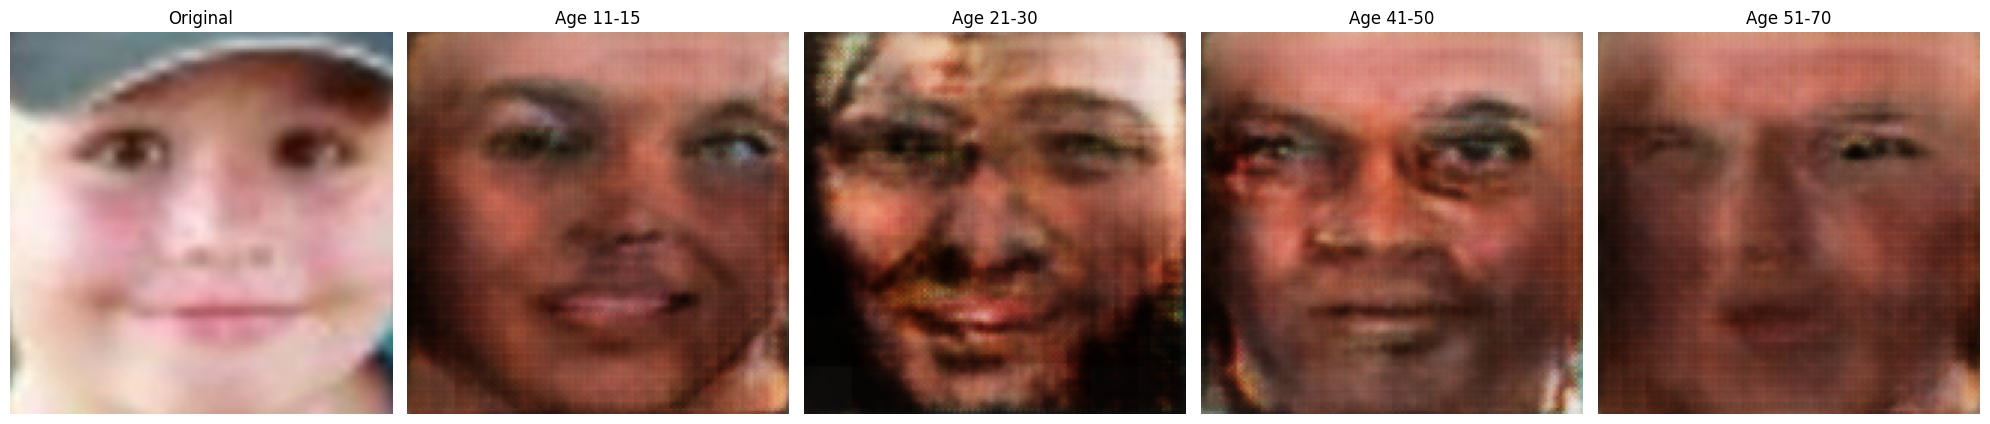

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


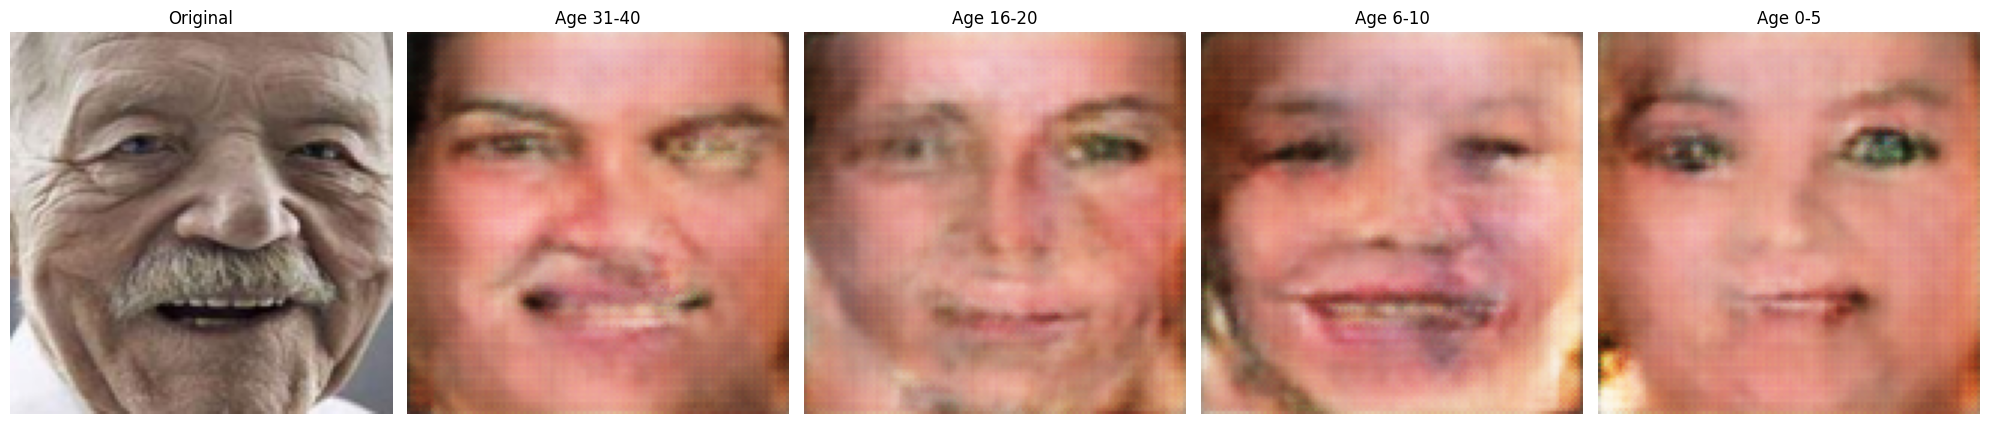

In [49]:
# Make sure you've defined the generator first
generator = build_generator(latent_dim)

# Or use the generator from your GAN model
generator = gan_model.generator

# Then use it for predictions or other operations


# Test with sample images from your dataset
# You can change this path to any image you want to test
test_image_path = "/kaggle/input/utkface-new/UTKFace/10_0_0_20170110220255346.jpg.chip.jpg"  # Young face

# Test age progression (young to old)
test_age_progression(test_image_path)

# Test with an older face
test_image_path = "/kaggle/input/utkface-new/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg"  # Older face

# Test age regression (old to young)
test_age_regression(test_image_path)
